In [241]:
import os
import glob
import string
import warnings
import pandas as pd
import numpy as np
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend import Legend
from matplotlib.colors import rgb2hex, hex2color
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.gridspec import GridSpecFromSubplotSpec

from colorspacious import cspace_convert
import seaborn as sns
import cmocean

from IPython.display import display, HTML

warnings.filterwarnings('ignore')

In [2]:
mpl.rcParams['xtick.major.width'] = 0.25
mpl.rcParams['ytick.major.width'] = 0.25
mpl.rcParams['grid.linewidth'] = 0.25

mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams['figure.dpi'] = 300

mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

mpl.rcParams['legend.fontsize'] = 6
mpl.rcParams['legend.frameon'] = False

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'

PANEL_LABEL_SIZE = 12
PANEL_LABEL_SIZE_SMALL = 9
LEGEND_TEXT_SIZE = 6
LABEL_TEXT_SIZE = 8
TICK_TEXT_SIZE = 4

FIG_WIDTH_1COL = 5.2
FIG_WIDTH_2COL = 7.5
FIG_HEIGHT_MAX = 8.75

## Data Functions

In [12]:
primary_data = read_table('cancer_data.csv')
extra_rows = {
    'KIRC/KIRP/KIRH': primary_data.loc['KIRC',:].values,
    'LUAD/LUSC': primary_data.loc['LUAD',:].values,
    'LGG/GBM': primary_data.loc['GBM', :].values
}
for k, v in extra_rows.items():
    primary_data.loc[k, :] = v
primary_data = primary_data.iloc[np.lexsort([primary_data.index, primary_data.organ_system]),:]

In [113]:
output_dir = '../../../tcga_paper/figures_v5'

In [14]:
human_body = plt.imread('Human_body_silhouette.png')

In [15]:
tumor_data_gse18549 = pd.read_csv('cup_project/external_validation/gse18549_sample_anns.csv', 
                         header=0, index_col=0)[['primary tumor site:ch1',
                                                 'metastatic tumor site:ch1']]

get_coords = lambda c: primary_data.loc[c, ['shadow_x', 'shadow_y']].values.tolist()
print(get_coords('ACC'))
metastatic_map = {'Omentum': [420, 850], 
                  'Adrenal': get_coords('ACC'), 
                  'Liver': get_coords('LIHC'), 
                  'Retroperitoneal': [420, 850], 
                  'Lung': get_coords('LUAD'), 
                  'Kidney': get_coords('KIRC'),
                  'Ankle': [380, 1965], 
                  'Chest wall': [500, 680], 
                  'Lymph Node': [300, 630], 
                  'Uterus': get_coords('UCEC'), 
                  'Pelvis': [375, 1200],
                  'Abdominal wall': [420, 890], 
                  'Rectum': get_coords('READ'),
                  'Ovary': get_coords('OV'), 
                  'Femur': get_coords('SARC'), 
                  np.nan: [np.nan, np.nan],
                  'Colon': get_coords('COAD'),
                  'Colon, left': get_coords('COAD'), 
                  'Colon, Rectum': get_coords('READ'), 
                  'Brain': get_coords('LGG'), 
                  'Bone': get_coords('SARC')}

tumor_map = {'Omentum': 'other', 
             'Adrenal': 'ACC', 
             'Liver': 'LIHC', 
             'Retroperitoneal': 'other', 
             'Lung': 'LUAD/LUSC', 
             'Kidney': 'KIRC/KIRP/KIRH',
             'Ankle': 'other', 
             'Chest wall': 'other', 
             'Lymph Node': 'other', 
             'Uterus': 'UCEC', 
             'Pelvis': 'other',
             'Abdominal wall': 'other', 
             'Rectum': 'READ',
             'Ovary': 'OV', 
             'Femur': 'SARC', 
             np.nan: 'other',
             'Colon': 'COAD',
             'Colon, left': 'COAD', 
             'Colon, Rectum': 'READ', 
             'Brain': 'LGG', 
             'Bone': 'SARC'}

primary_map = {'Ovary': 'OV', 
               'Renal': 'KIRC', 
               'Colon': 'COAD', 
               'Ovarian vs Peritoneal': 'OV', 
               'Lung': 'LUAD',
               'GE junction': 'STAD',
               'Pancreas': 'PAAD', 
               'Rectal': 'READ', 
               'Breast': 'BRCA',
               'Adenocarcinoma, most likely GI': 'STAD', 
               'Adenocarcinoma, possibly H&N': 'HNSC',
               'Breast carcinoma': 'BRCA', 
               'Renal clear cell': 'KIRC', 
               'Colon adenocarcinoma': 'COAD',
               'Lung adenocarcinoma': 'LUAD',
               'Esophageal adenocarcinoma': 'ESCA',
               'Colorectal adenocarcinoma': 'READ', 
               'Breast mucinous adenocarcinoma': 'BRCA',
               'Prostate': 'PRAD'
              }

tumor_data_gse18549['path'] = tumor_data_gse18549.iloc[:,:2].apply(lambda r: '-->'.join(map(str, r)), axis=1).values
tumor_data_gse18549['primary'] = tumor_data_gse18549.iloc[:,0].map(primary_map)
tumor_data_gse18549['tumor_coords_x'] = tumor_data_gse18549.iloc[:,1].map(lambda r: metastatic_map[r][0])
tumor_data_gse18549['tumor_coords_y'] = tumor_data_gse18549.iloc[:,1].map(lambda r: metastatic_map[r][1])
tumor_data_gse18549['tumor'] = tumor_data_gse18549.iloc[:,1].map(lambda r: tumor_map[r])

[582.6358974358975, 766.4879518072288]


In [301]:
metric_functions = {
    'pos pred value': lambda tp, fn, fp, tn: tp / (tp + fp),
    'sensitivity': lambda tp, fn, fp, tn: tp / (tp + fn),
    'specificity': lambda tp, fn, fp, tn: tn / (tn + fp),
    'accuracy': lambda tp, fn, fp, tn: (tp + tn) / (tp + fn + fp + tn),
    'positive likelihood ratio': lambda tp, fn, fp, tn: tp * (fp + tn) / fp / (tp + fn),
    'negative likelihood ratio': lambda tp, fn, fp, tn: fn * (fp + tn) / tn / (tp + fn)
}

In [256]:
def group_metrics(contingency, groupby, metrics=['pos pred value', 'sensitivity', 'specificity']):
    names = groupby.groups.keys()
    groups = list(groupby.groups.values())

    L = len(groups)
    cont_reduced = np.zeros((L, L), dtype=int)
    for i, j in product(range(L), repeat=2):
        a = groups[i]
        b = groups[j]
        ai = contingency.index.isin(a)
        bi = contingency.columns.isin(b)

        if (not ai.any()) or (not bi.any()): continue
        cont_reduced[i, j] = contingency.loc[ai, bi].values.sum()
    cont_reduced = clean_table(pd.DataFrame(cont_reduced, index=names, columns=names))

    ms = pd.DataFrame(0, index=cont_reduced.columns, columns=metrics)
    for k in range(cont_reduced.shape[1]):
        ak = cont_reduced.columns == cont_reduced.columns[k]
        bk = cont_reduced.index == cont_reduced.columns[k]
        # columns are reference, so [~ak, a] is FN and [ak, ~ak] is FP
        tp, fn, fp, tn = (cont_reduced.loc[bk, ak].values.sum(),
                          cont_reduced.loc[~bk, ak].values.sum(),
                          cont_reduced.loc[bk, ~ak].values.sum(),
                          cont_reduced.loc[~bk, ~ak].values.sum())
        #print(cont_reduced.columns[k], tp, fn, fp, tn)
        ms.iloc[k, :] = [metric_functions[metric](tp, fn, fp, tn)
                         for metric in metrics]
        #ms.iloc[k, :] = [tp / (tp + fp), tp / (tp + fn), tn / (tn + fp)]

    #print(cont_reduced.shape, ms.shape)
    return cont_reduced, clean_table(ms)

In [18]:
def _construct_metrics(contingency, metrics=['pos pred value', 'sensitivity', 'specificity']):
    ms = pd.DataFrame(0, index=contingency.index, columns=metrics)
    L = contingency.shape[1]
    for k in range(L):
        ak = contingency.columns == contingency.columns[k]
        bk = contingency.index == contingency.columns[k]
        tp, fn, fp, tn = (contingency.loc[bk, ak].values.sum(),
                          contingency.loc[~bk, ak].values.sum(),
                          contingency.loc[bk, ~ak].values.sum(),
                          contingency.loc[~bk, ~ak].values.sum())
        ms.iloc[k, :] = [metric_functions[metric](tp, fn, fp, tn)
                         for metric in metrics]
    return ms

def load_subtype_metrics(directory, metrics=['pos pred value', 'sensitivity', 'specificity']):
    table_files = glob.glob(os.path.join(directory, '*table.csv'))
    metric_files = glob.glob(os.path.join(directory, '*metrics'))
    
    ms = []
    for table_file, metric_file in zip(table_files, metric_files):
        cancer_type = metric_file.split(os.sep)[-1].split('_')[0]
        m = read_metrics(metric_file)
        
        t = clean_table(read_table(table_file))
        n = t.sum(axis=0).values
        if m.shape[1] < 2:
            m = _construct_metrics(t)
        else:
            m = m.loc[:, metrics]
        
        m['primary_type'] = cancer_type
        m['n_samples'] = n
        ms.append(m)
    return pd.concat(ms, axis=0)

## Plotting functions

In [286]:
def metrics_scatter(ax, data, colors, sizes, metrics=['sensitivity', 'specificity'], 
                    show_legend=True, legend_cols=2):
    assert len(metrics) == 2
    for k, (label, row) in enumerate(data.iterrows()):
        ax.scatter(row[metrics[0]], row[metrics[1]], label=label, color='none',
                   edgecolors=colors[k], s=sizes[k], facecolors='none', lw=1, alpha=0.85)
    
    legend = Legend(ax, *ax.get_legend_handles_labels(), handletextpad=-0.1, columnspacing=0.7,
                    loc='lower right', ncol=legend_cols)
    if show_legend:
        ax.add_artist(legend)
    
    ax.set_xlabel(metrics[0].capitalize())
    ax.set_ylabel(metrics[1].capitalize())
    ax.set_xlim(-0.015, 1.05)
    ax.set_ylim(-0.015, 1.05)

    ax.axvline(0.5, color='0.6', lw=0.25)
    ax.axhline(0.5, color='0.6', lw=0.25)
    
    return ax

In [20]:
def annotated_heatmap(ax, data, colors_x, colors_y,
                      annotate=True, cmap='binary', show_ylabel=True,
                      annotate_size=LEGEND_TEXT_SIZE):
    # This is the function to make annotated heatmaps
    ax.axis('off')
    _gs = GridSpecFromSubplotSpec(2, 2, subplot_spec=ax, wspace=0, hspace=0,
                                  height_ratios=[49, 1], width_ratios=[1, 49])
    ax_m = ax.figure.add_subplot(_gs[0, 1])
    ax_v = ax.figure.add_subplot(_gs[0, 0])
    ax_h = ax.figure.add_subplot(_gs[1, 1])
    
    normed = data / data.sum(axis=0)
    normed.fillna(0, inplace=True)
    sns.heatmap(normed, annot=data if annotate else False, fmt='d', 
                ax=ax_m, square=False, cmap=cmap, cbar=False,
                xticklabels=1, yticklabels=1,
                annot_kws=dict(fontsize=annotate_size))
    
    for k, color in enumerate(colors_x):
        ax_h.barh(0, 1, left=k, color=color, height=1)
    for k, color in enumerate(colors_y):
        ax_v.bar(0, 1, bottom=k, color=color, width=1)

    transfer_ticks(ax_m, ax_h, which='x', rotation=90)
    transfer_ticks(ax_m, ax_v, which='y')
    
    fix_spines(ax_h, [], keep_ticks=True)
    fix_spines(ax_v, [], keep_ticks=True)
    
    ax_h.set_xlabel('Reference')
    if show_ylabel:
        ax_v.set_ylabel('Prediction')    

    return ax

In [21]:
def marginal_heatmap(ax, data_m, data_x, data_y, 
                     colors_x, colors_y, colors_x_bar, colors_y_bar, 
                     marg_xlabel='Samples per class', marg_ylabel='Pos Pred Value', 
                     cmap='binary', annotate=True, annotate_size=LEGEND_TEXT_SIZE):
    # This is the function for figure 1

    ax.axis('off')
    _gs = GridSpecFromSubplotSpec(4, 4, subplot_spec=ax, wspace=0.01, hspace=0.01,
                                  height_ratios=[25, 1, 49, 1],
                                  width_ratios=[1, 49, 1, 25])
    ax_m  = ax.figure.add_subplot(_gs[2, 1])
    ax_h1 = ax.figure.add_subplot(_gs[3, 1])
    ax_h2 = ax.figure.add_subplot(_gs[1, 1], sharex=ax_m)
    ax_x  = ax.figure.add_subplot(_gs[0, 1], sharex=ax_m)
    ax_v1 = ax.figure.add_subplot(_gs[2, 0])
    ax_v2 = ax.figure.add_subplot(_gs[2, 2], sharey=ax_m)
    ax_y  = ax.figure.add_subplot(_gs[2, 3], sharey=ax_m)
    
    normed = data_m / data_m.sum(axis=0)
    normed.fillna(0, inplace=True)
    sns.heatmap(normed, annot=data_m if annotate else False, fmt='d', 
                ax=ax_m, square=False, cmap=cmap, cbar=False,
                xticklabels=1, yticklabels=1,
                annot_kws=dict(fontsize=annotate_size))
    
    ax_x.bar(np.arange(data_x.shape[0]) + 0.5, data_x, 
             width=0.9, color=colors_x)
    ax_y.barh(np.arange(data_y.shape[0]) + 0.5, data_y, 
              height=0.9, color=colors_y)
    
    for k, color in enumerate(colors_x_bar):
        ax_h1.barh(0, 1, left=k, color=color, height=1)
        ax_h2.barh(0, 1, left=k, color=color, height=1)
    for k, color in enumerate(colors_y_bar):
        ax_v1.bar(0, 1, bottom=k, color=color, width=1)
        ax_v2.bar(0, 1, bottom=k, color=color, width=1)
    for (i, ci), (j, cj) in product(enumerate(colors_x_bar), enumerate(colors_y_bar)):
        if ci != cj: continue
        patch = mpatches.Rectangle([i, j], 1, 1, color=ci, 
                                   alpha=0.2, lw=0)
        ax_m.add_artist(patch)

    transfer_ticks(ax_m, ax_h1, which='x', rotation=90)
    transfer_ticks(ax_m, ax_v1, which='y')
    
    fix_spines(ax_h1, [], keep_ticks=True)
    fix_spines(ax_v1, [], keep_ticks=True)
    fix_spines(ax_h2, [], keep_ticks=False)
    fix_spines(ax_v2, [], keep_ticks=False)
    fix_spines(ax_x, ['left'], keep_ticks=False)
    fix_spines(ax_y, ['bottom'], keep_ticks=False)
    
    ax_h1.set_xlabel('Reference')
    ax_v1.set_ylabel('Prediction')    
    
    ax_x.set_ylabel(marg_xlabel)
    ax_y.set_xlabel(marg_ylabel)

    return ax

In [22]:
def barplot(ax, data, colors, colors_bar, labels, xlabel):
    ax.axis('off')
    _gs = GridSpecFromSubplotSpec(1, 2, subplot_spec=ax, wspace=0, hspace=0,
                                  width_ratios=[1, 49])
    ax_m = ax.figure.add_subplot(_gs[0, 1])
    ax_v = ax.figure.add_subplot(_gs[0, 0])
    
    L = len(labels)
    y = np.arange(L)
    ax_m.barh(y, data, color=colors, height=0.9, zorder=3)
    
    transfer_ticks(ax_m, ax_v, which='y')

    for k, color in enumerate(colors_bar):
        ax_v.bar(0, 1, bottom=k-0.5, color=color, width=1)
    
    ax_v.set_yticks(y)
    ax_v.set_yticklabels(labels)
        
    ax_m.set_xlabel(xlabel)
    ax_m.grid(True, which='major', zorder=0)
    
    ax_m.set_ylim(0-0.5, L-0.5)
    ax_v.set_ylim(*ax_m.get_ylim())
    
    fix_spines(ax_m, ['left'], keep_ticks=True)
    fix_spines(ax_v, [], keep_ticks=True)
    
    ax_m.invert_yaxis()
    ax_v.invert_yaxis()
    
    return ax

In [145]:
def subtype_combined_barplot(ax, data, colors, colors_bar, labels, bar_labels, xlabel, bar_text=True,
                             show_ylabels=True):
    ax.axis('off')
    _gs = GridSpecFromSubplotSpec(1, 2, subplot_spec=ax, wspace=0, hspace=0,
                                  width_ratios=[1, 49])
    ax_m = ax.figure.add_subplot(_gs[0, 1])
    ax_v = ax.figure.add_subplot(_gs[0, 0])
    
    L = len(bar_labels)
    y = np.arange(L)
    ax_m.barh(y, data, color=colors, height=0.9, zorder=3)
    
    transfer_ticks(ax_m, ax_v, which='y')

    for k, color in enumerate(colors_bar):
        ax_v.bar(0, 1, bottom=k-0.5, color=color, width=1)
    
    if bar_text:
        bars = ax_m.patches
        for k, (color, bar, label) in enumerate(zip(colors, bars, bar_labels)):
            bar_width = bar.get_width()
            lum = sns.utils.relative_luminance(color)
            text_color = ".15" if (lum > .308) or (bar_width < 0.05) else "w"
        
            t = ax_m.text(0.02, k, label, color=text_color, va='center', size=TICK_TEXT_SIZE,
                          clip_on=True, wrap=True)
            if bar_width > 0.1:
                t.set_clip_path(bar)
    
    label_counts = pd.value_counts(labels).sort_index()
    ax_v.set_yticks(label_counts.cumsum() - 2)
    ax_v.set_yticklabels(label_counts.index)
        
    ax_m.set_xlabel(xlabel)
    if data.max() < 1.01:
        ax_m.set_xlim(0, 1.01)
        #ax_m.set_xticks(np.arange(0, 1.1, 0.1))
        ax_m.set_xticks(np.arange(0, 1.1, 0.2))
    ax_m.grid(True, which='major', zorder=0)
    
    ax_m.set_ylim(0-0.5, L-0.5)
    ax_v.set_ylim(*ax_m.get_ylim())
    
    fix_spines(ax_m, ['left'], keep_ticks=True)
    fix_spines(ax_v, ['left'], keep_ticks=True)
    
    ax_m.invert_yaxis()
    ax_v.invert_yaxis()
    
    if not show_ylabels:
        ax_v.set_yticklabels([])
    
    return ax

In [24]:
def anatomical_plot(ax, data, links=None, subset=None,
                    sizeby='n_samples', colorby='shade',
                    show_legend=True, show_size_legend=True,
                    legend_cols=None, size_legend_cols=2, alpha=1.0, scaling=0.1):

    #scaling = 0.1
    
    if colorby not in ['shade', 'hue']:
        raise Exception("`colorby` must be either `'shade'` or `'hue`'.")
    if not isinstance(sizeby, int) and sizeby not in data.columns:
        raise Exception("`sizeby` needs to be an int or in dataset cols.")
    elif sizeby in data.columns:
        size_is_col = True
    else:
        size_is_col = False

    ax.imshow(human_body, aspect='equal')
    ax.set_anchor('NW')

    used_labels = set()
    main_handles, main_labels = [], []
    for abbrev, row in data.sort_values('organ_system').iterrows():
        if subset is not None and abbrev not in subset: continue

        alpha = alpha
        zorder = 5
        if links is not None:
            in_links = any(abbrev in link for link in links)
            if not in_links:
                alpha = 0.5
                zorder = 1

        if colorby == 'hue':
            ncol = 2 if legend_cols is None else legend_cols
            label = abbrev
        else:
            ncol = 1 if legend_cols is None else legend_cols
            label = row.organ_system

        if label in used_labels:
            label = ''
        else:
            used_labels.add(label)

        scat = ax.scatter(row.shadow_x, row.shadow_y, label=label, alpha=alpha,
                          color=row[colorby], edgecolors='k', zorder=zorder, lw=0.5,
                          s=row[sizeby]*scaling if size_is_col else sizeby)
        if label:
            main_handles.append(scat)
            main_labels.append(label)
    #ax.axis('off')
    
    get_coords = lambda c1, c2: list(zip(*cancer_data.loc[cancer_data.index.isin([c1,c2]),
                                                          ['shadow_x', 'shadow_y']].values))
    get_coords2 = lambda c1, c2: list(cancer_data.loc[cancer_data.index.isin([c1,c2]),
                                                      ['shadow_x', 'shadow_y']].values)
    get_coords = lambda c: list(primary_data.loc[c, ['shadow_x', 'shadow_y']].values)
    if links is not None:
        # links should be list of lists/tuples with the following form:
        # 1. ['CLASS1', 'CLASS2', width_scale]
        # 2. ['CLASS1', (x_coord, y_coord), width_scale]
        for class1, class2, scale in links:
            #xs, ys = get_coords(class1, class2)
            x1, y1 = get_coords(class1)
            if isinstance(class2, str):
                x2, y2 = get_coords(class2)
            else:
                x2, y2 = class2
            dx, dy = x2 - x1, y2 - y1
        
            #(x, y), p2 = get_coords2(class1, class2)
            #dx, dy = p2[0] - x, p2[1] - y
            width = 15 + 10 * scale * scaling
            print(class1)
            color = data.loc[class1, 'hue']
            
            scat = ax.scatter(x2, y2, alpha=alpha, marker='s',
                          color='0.8', edgecolors='k', zorder=2, lw=0.5,
                          s=row[sizeby]*scaling if size_is_col else sizeby)
        
            arrow = mpatches.FancyArrow(x1, y1, dx, dy, width=width,
                                        head_length=2*width, head_width=1.3*width,
                                        length_includes_head=True,
                                        edgecolor='k', lw=0.8, alpha=1., zorder=3,
                                        facecolor=color)
            ax.add_artist(arrow)
            
    
    if show_legend:
        main_legend = Legend(ax, main_handles, main_labels, bbox_to_anchor=(0.5, 0.1), 
                             loc='lower center', handletextpad=-0.1, ncol=ncol)
        for k in range(len(main_legend.legendHandles)):
            main_legend.legendHandles[k]._sizes = [60]
        ax.add_artist(main_legend)
            
        if size_is_col and show_size_legend:
            sizes = [50, 200, 500, 1000]
            handles = [ax.scatter([], [], s=s*scaling, c='0.85', edgecolors='k', label=str(s))
                       for s in sizes]

            size_legend = Legend(ax, handles, list(map(str, sizes)), loc='lower center', ncol=size_legend_cols, 
                                 labelspacing=1, handletextpad=0.1, #columnspacing=0.1, 
                                 bbox_to_anchor=(0.5, 0.0), scatteryoffsets=[0.5])
            ax.add_artist(size_legend)
    ax.set_adjustable('datalim')
    return ax

# Figure 1 - Schema, data

# METRICS

In [323]:
def median_metrics(name, table_file, metrics_file, sort=True, group=True, blacklist=[],
                   metrics=['pos pred value', 'specificity', 'sensitivity']):
    table = read_table(table_file)
    table = clean_table(table, blacklist=blacklist)
    if sort:
        table = sort_rectangular_table(table, primary_data.index)
    
    metrics_data = read_metrics(metrics_file)
    metrics_data = metrics_data.loc[table.columns, :]
    
    total_samples = table.sum(axis=0).sum()
    medians = metrics_data.median().loc[metrics] * 100
    medians['samples'] = total_samples
    medians = pd.DataFrame(medians, columns=[name]).T


    
    if group:
        grouping = primary_data.loc[table.index.union(table.columns),:].groupby('organ_system')
        table_group, metrics_group = group_metrics(table, grouping, metrics=metrics)
        print(metrics_data.min()['specificity'], metrics_group.min()['specificity'])
        print(metrics_data.min()['pos pred value'], metrics_group.min()['pos pred value'])
        table_group = sort_rectangular_table(clean_table(table_group), primary_data.organ_system.unique())
        for m in metrics:
            medians[m + '_group'] = metrics_group.median()[m] * 100
        if name == 'Metastasis':
            print(metrics_data)
            print(metrics_group)
    medians.sort_index(axis=1, inplace=True)
    
    display(HTML(medians.to_html()))
    
# Main
table_file = 'cup_project/primary_type/rf_contingency.csv'
metrics_file = 'cup_project/primary_type/rf_metrics.csv'
median_metrics('Main', table_file, metrics_file)

# External validation
metrics_file = 'cup_project/external_validation/gse2109_metrics.csv'
table_file = 'cup_project/external_validation/gse2109_contingency.csv'
median_metrics('External validation', table_file, metrics_file, blacklist=['LGG/GBM'])

# Metastasis
metrics_file = 'cup_project/external_validation/gse18549_metrics.csv'
table_file = 'cup_project/external_validation/gse18549_contingency.csv'
median_metrics('Metastasis', table_file, metrics_file)


# PDX
metrics_file = 'cup_project/external_validation/pdx_metrics_new.csv'
table_file = 'cup_project/external_validation/pdx_contingency_new.csv'
median_metrics('PDX', table_file, metrics_file)#, blacklist=['OV'])

# Subtypes
subtype_directory = 'cup_project/subtype/'
subtype_data = load_subtype_metrics(subtype_directory)
subtype_data.drop(labels=['NF1'], axis=0, inplace=True)
subtype_data['shade'] = primary_data.loc[subtype_data.primary_type, 'hue'].values

subtype_df = pd.DataFrame([[subtype_data['pos pred value'].median(), subtype_data.specificity.median(), 
                           subtype_data.sensitivity.median(), subtype_data.n_samples.sum()]],
                          columns=['pos pred value', 'specificity', 'sensitivty', 'samples'], index=['Subtypes'])
display(HTML(subtype_df.to_html()))

ovarian_table = 'cup_project/external_validation_subtype/ovarian_aocs_contingency.csv'
ovarian_metrics = 'cup_project/external_validation_subtype/ovarian_aocs_metrics.csv'
median_metrics('Ovarian subtype', ovarian_table, ovarian_metrics, sort=False, group=False)

breast_table = 'cup_project/external_validation_subtype/breast_contingency.csv'
breast_metrics = 'cup_project/external_validation_subtype/breast_metrics.csv'
median_metrics('Breast subtype', breast_table, breast_metrics, sort=False, group=False)

0.9892059420754521 0.9945918104558331
0.0 0.8596491228070176


,pos pred value,pos pred value_group,samples,sensitivity,sensitivity_group,specificity,specificity_group
Main,96.385542,98.540909,9642.0,97.159091,98.497631,99.915469,99.898125


0.980897009966777 0.9588709677419355
0.45454545454545503 0.7931034482758621


,pos pred value,pos pred value_group,samples,sensitivity,sensitivity_group,specificity,specificity_group
External validation,93.484419,85.281362,1552.0,78.125,85.868106,99.277689,98.056986


0.9102564102564101 0.9102564102564102
0.5 0.5
                sensitivity  specificity  pos pred value  neg pred value  \
abbrev                                                                     
COAD               0.200000     1.000000        1.000000        0.654321   
BRCA               0.857143     0.972973        0.857143        0.972973   
OV                 0.785714     0.986486        0.916667        0.960526   
LUAD/LUSC          0.700000     0.910256        0.500000        0.959459   
KIRC/KIRP/KIRH     1.000000     1.000000        1.000000        1.000000   
PRAD               1.000000     1.000000        1.000000        1.000000   

                precision    recall        f1  prevalence  detection rate  \
abbrev                                                                      
COAD             1.000000  0.200000  0.333333    0.397727        0.079545   
BRCA             0.857143  0.857143  0.857143    0.159091        0.136364   
OV               0.916667  0.785714  

,pos pred value,pos pred value_group,samples,sensitivity,sensitivity_group,specificity,specificity_group
Metastasis,95.833333,94.117647,88.0,82.142857,81.428571,99.324324,98.630137


0.9788732394366201 0.9571984435797666
0.5714285714285711 0.5


,pos pred value,pos pred value_group,samples,sensitivity,sensitivity_group,specificity,specificity_group
PDX,97.419872,84.722222,325.0,75.961538,83.333333,99.492947,99.156118


,pos pred value,specificity,sensitivty,samples
Subtypes,0.833426,0.945414,0.876732,3367


,pos pred value,samples,sensitivity,specificity
Ovarian subtype,81.150794,215.0,88.361446,94.889425


,pos pred value,samples,sensitivity,specificity
Breast subtype,76.974234,1784.0,72.405006,94.497425


# Figure 2 - Primary classification

In [69]:
def setup_fig2():
    #fig, axarr = plt.subplots(2, 2, figsize=(FIG_WIDTH_2COL, FIG_HEIGHT_MAX),
    #                          gridspec_kw=dict(height_ratios=[2, 1],
    #                                           width_ratios=[1.5, 1],
    #                                           wspace=0.5, hspace=0.5))
    fig = plt.figure(figsize=(FIG_WIDTH_1COL, FIG_HEIGHT_MAX))
    
    gs = plt.GridSpec(5, 3, hspace=0.7, wspace=0.7, right=0.98, left=0.24, top=1)
    
    ax1 = fig.add_subplot(gs[:3, :])
    ax2 = fig.add_subplot(gs[3:, :2])
    ax3 = fig.add_subplot(gs[3, 2])
    ax4 = fig.add_subplot(gs[4, 2])
    axs = (ax1, ax2, ax3, ax4)
    
    for ax in axs:
        fix_spines(ax, ['left', 'bottom'], sep=0)

    label_panels(axs)
    
    return (fig, ) + axs

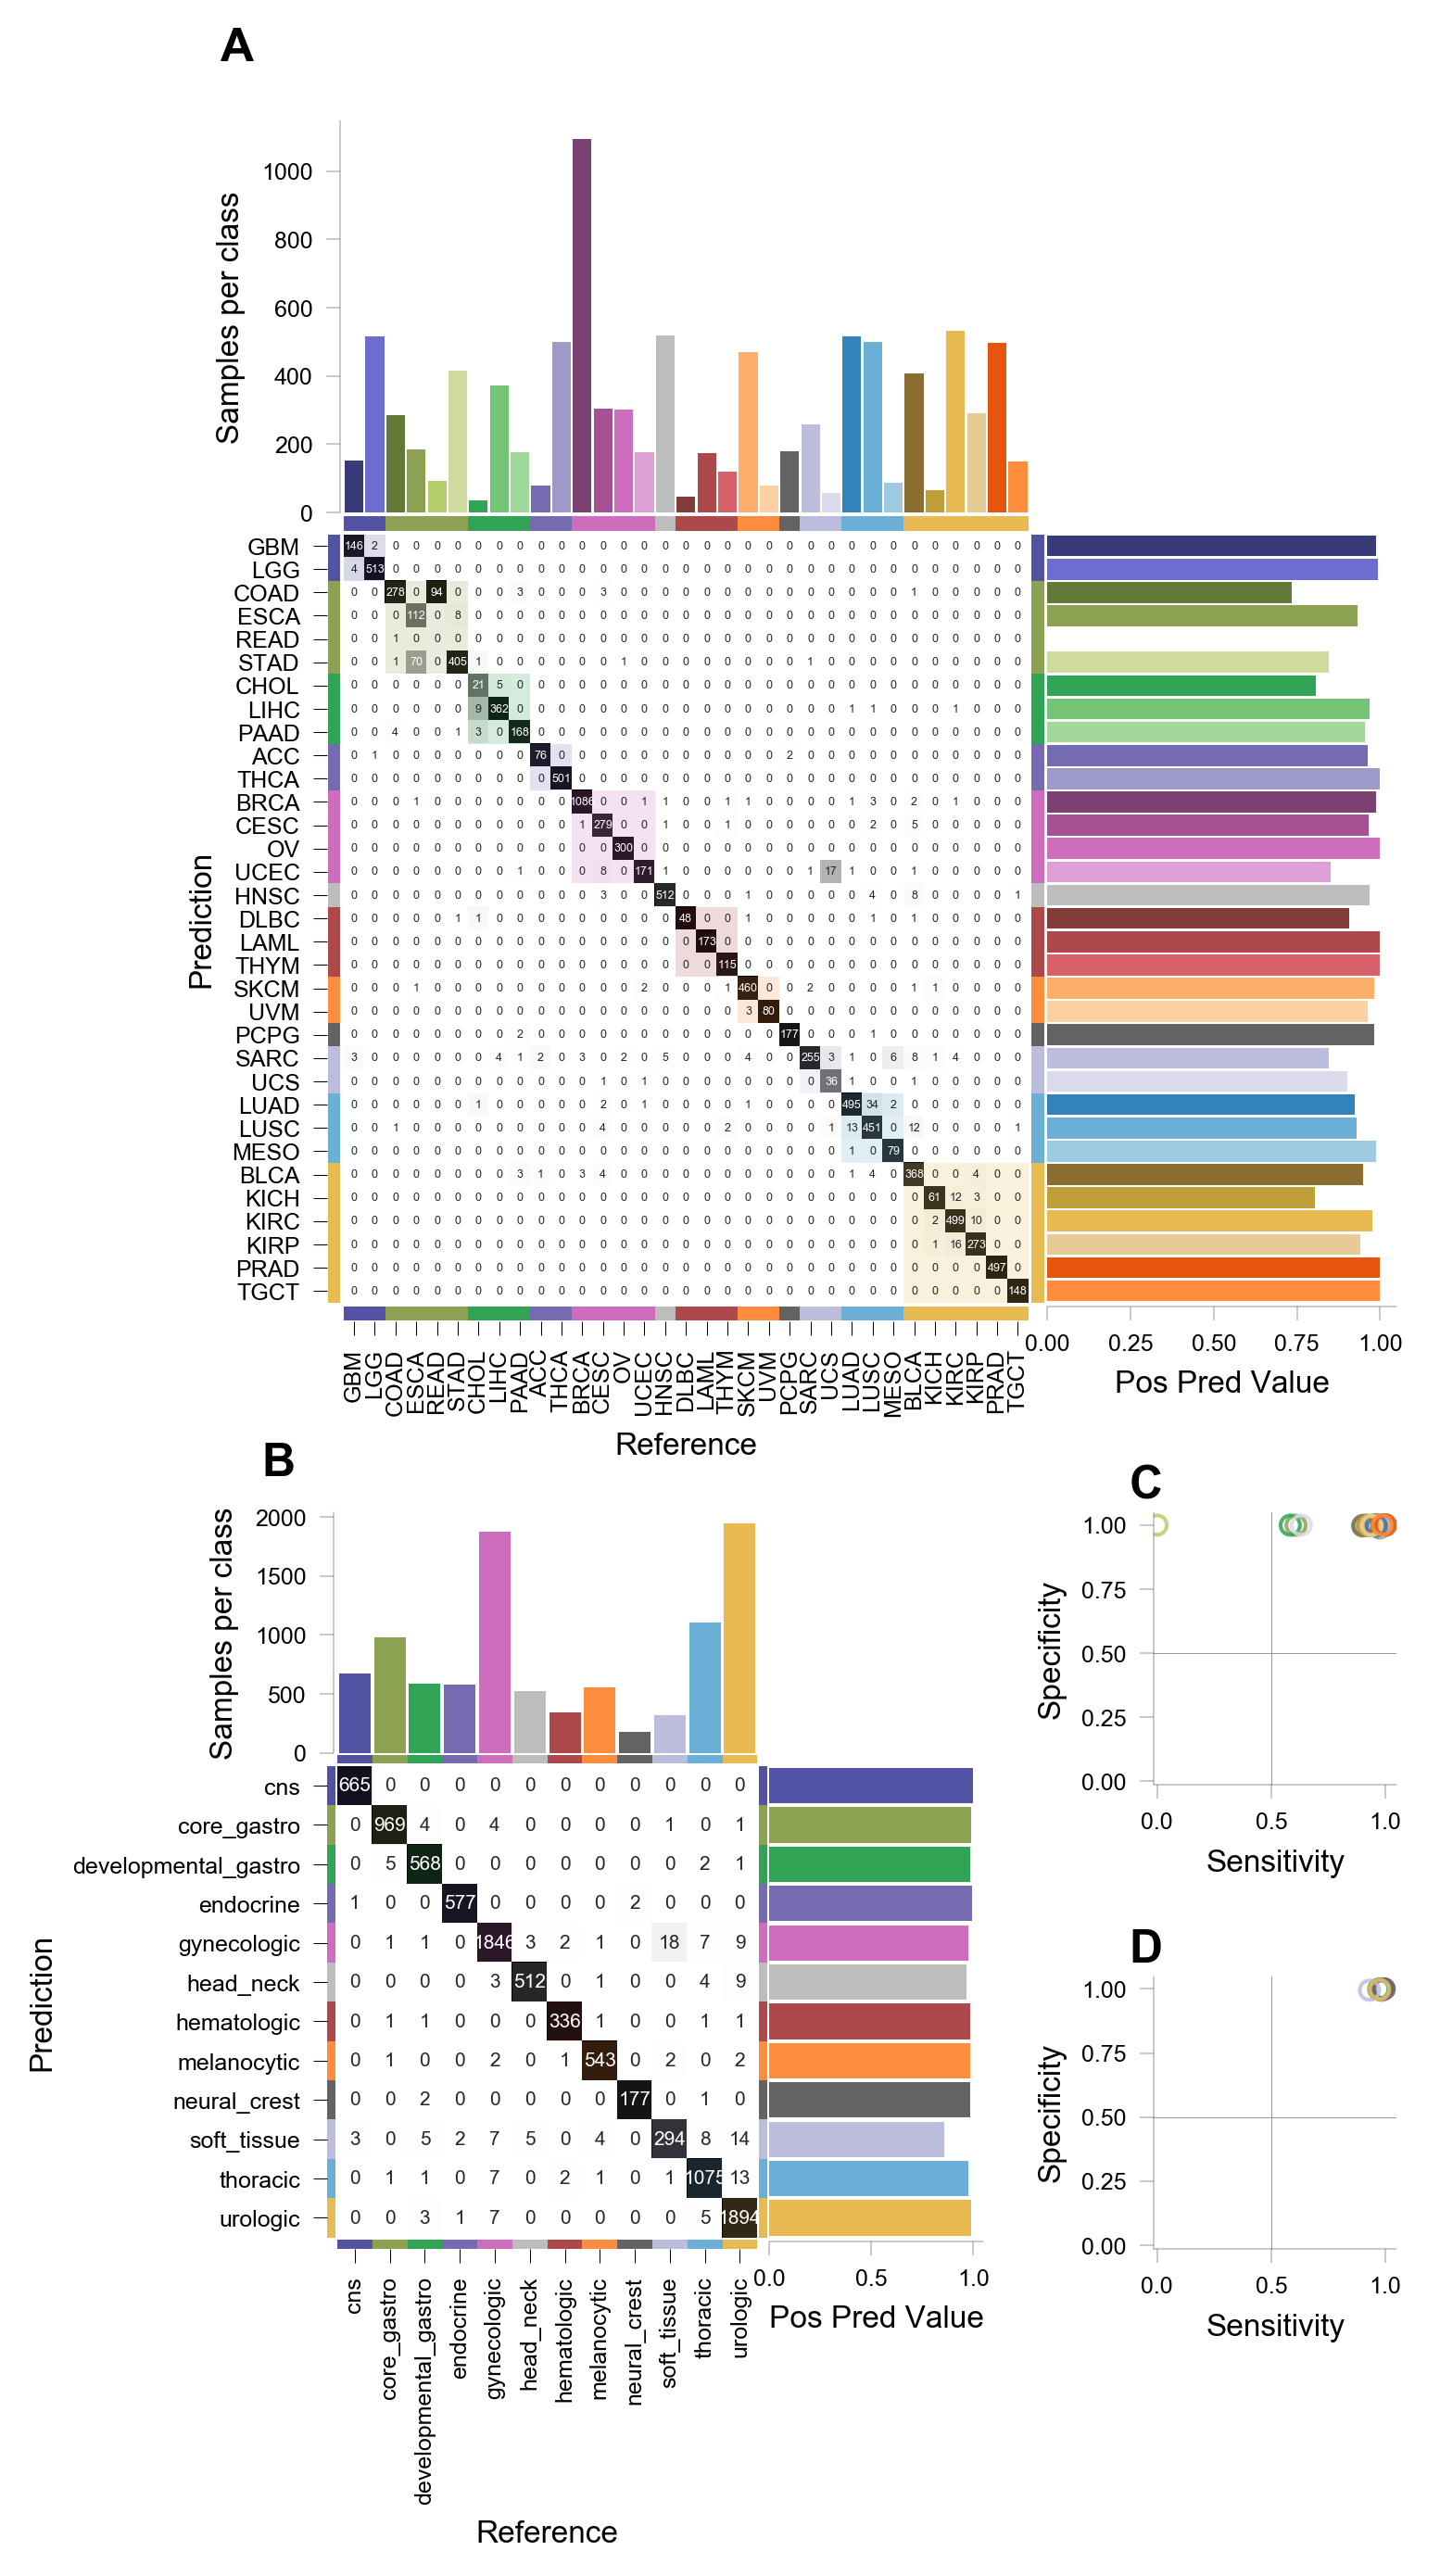

In [315]:
table_file = 'cup_project/primary_type/rf_contingency.csv'
metrics_file = 'cup_project/primary_type/rf_metrics.csv'

table = read_table(table_file)
table = sort_rectangular_table(clean_table(table), primary_data.index)

metrics = read_metrics(metrics_file)
metrics = metrics.loc[table.index, :]#['pos pred value', 'sensitivity', 'specificity']]

colors_x, colors_y = get_heatmap_colors(table, primary_data, 'hue', other_col=None)
colors_x_bar, colors_y_bar = get_heatmap_colors(table, primary_data, 'shade', other_col=None)
sizes = np.ones(len(colors_x)) * 25

# samples per class
marginal_x = table.sum(axis=0)
marginal_y = metrics['pos pred value'].values

fig, heatmap_ax1, heatmap_ax2, scatter_ax1, scatter_ax2 = setup_fig2()

marginal_heatmap(heatmap_ax1, table, marginal_x, marginal_y, 
                 colors_x, colors_y, colors_x_bar, colors_y_bar,
                 annotate_size=3)
metrics_scatter(scatter_ax1, metrics, colors_x, sizes, legend_cols=4, show_legend=False,
                metrics=['sensitivity', 'specificity'])

table_group, metrics_group = group_metrics(table, primary_data.groupby('organ_system'))

colors_x, colors_y = get_heatmap_colors(table_group, primary_data, 'shade', other_col='organ_system')
sizes = np.ones(len(colors_x)) * 25

# samples per class
marginal_x = table_group.sum(axis=0)
marginal_y = metrics_group['pos pred value'].values

marginal_heatmap(heatmap_ax2, table_group, marginal_x, marginal_y, 
                 colors_x, colors_y, colors_x, colors_y, annotate_size=5)
metrics_scatter(scatter_ax2, metrics_group, colors_x, sizes, show_legend=False,
                metrics=['sensitivity', 'specificity'])

fig.savefig('../../../tcga_paper/figures_v5/fig_2_v5.png', dpi=300)

In [72]:
metrics.median(), metrics.min()
metrics_group.median(), metrics_group.min()
table.sum().sum()

9642

# Figure 3 - Dimensionality reduction

In [116]:
umap_data = read_table('../../notebooks/umap_2d.csv')

In [117]:
umap_data['hue'] = umap_data.label.map(lambda lab: primary_data.loc[lab, 'hue'])
umap_data['shade'] = umap_data.label.map(lambda lab: primary_data.loc[lab, 'shade'])

In [118]:
primary_data.groupby?

In [119]:
umap_data = umap_data.loc[umap_data.label.apply(lambda i: primary_data.index.get_loc(i)).sort_values().index, :]

In [120]:
from adjustText import adjust_text

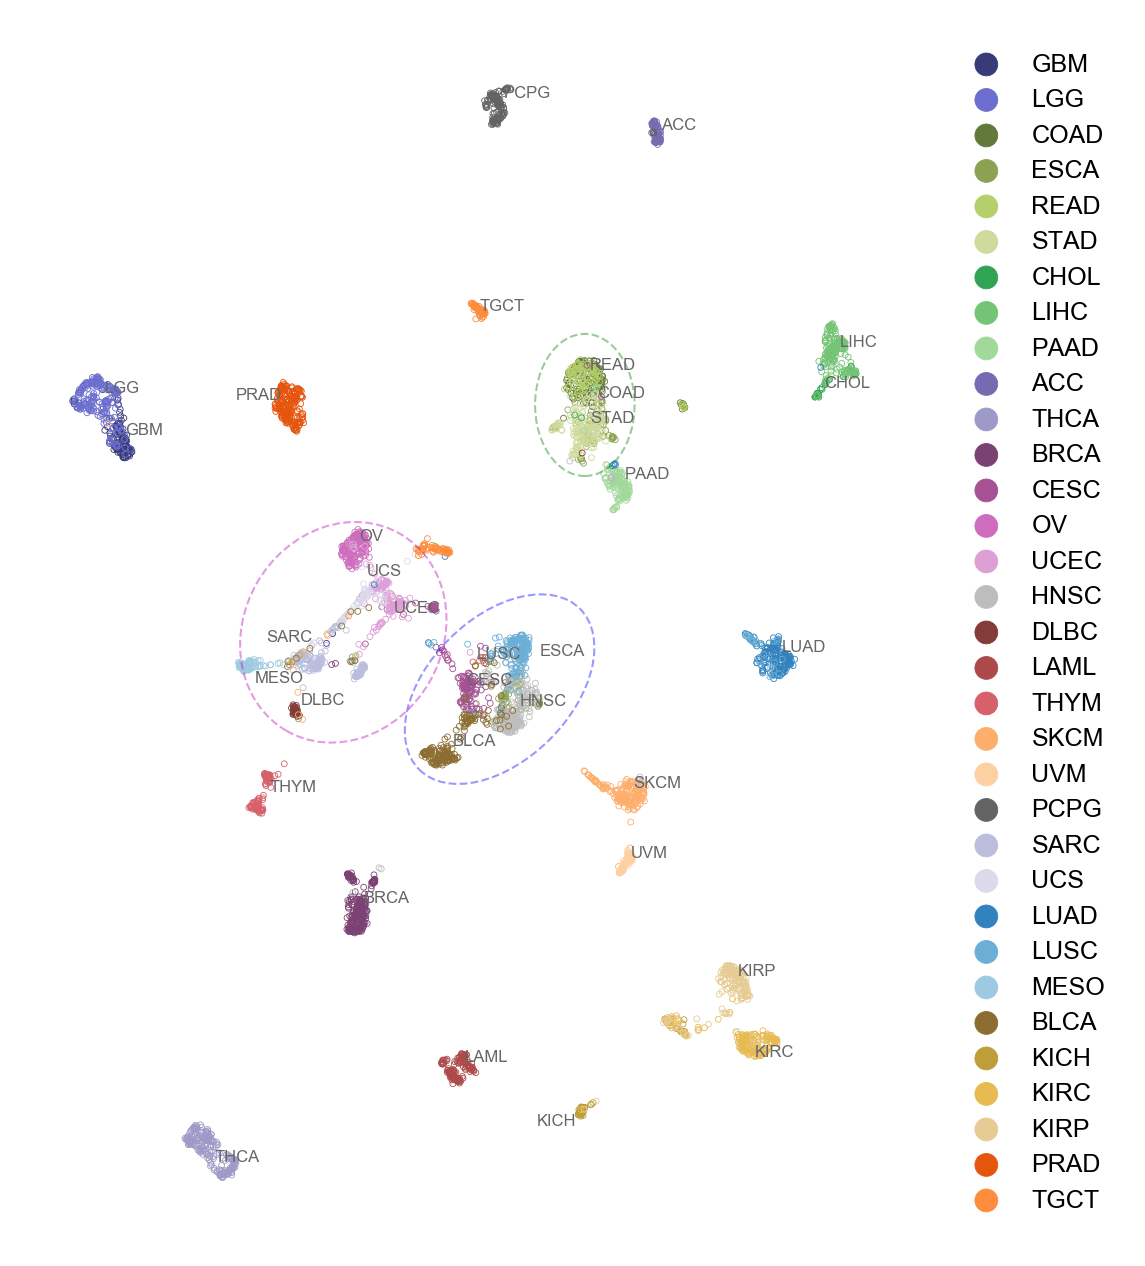

In [172]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH_1COL, 4))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
labels, handles = [], []
xs, ys, texts = [], [], []
for lab, inds in umap_data.groupby('label', sort=False):
    #if lab not in ['STAD', 'READ', 'COAD', 'ESCA']: continue
    #if lab not in ['LUSC', 'CESC', 'BLCA', 'ESCA']: continue
    #if lab not in ['OV', 'SARC', 'UCS', 'UCEC']: continue
    #if lab not in ['KIRC', 'KIRH', 'KIRP']: continue
    scat = ax.scatter(inds['x'], inds['y'], edgecolors=inds['hue'], s=2,
                      lw=0.2, alpha=1, facecolors='none')
    cx = inds['x'].median()
    cy = inds['y'].median()
    xs.append(cx)
    ys.append(cy)
    texts.append(plt.text(cx, cy, lab, size=TICK_TEXT_SIZE, color='0.4'))
    
    if lab not in labels:
        labels.append(lab)
        handles.append(scat)
        
adjust_text(texts, xs, ys, expand_points=(1.5, 1.5), force_points=1)

e1 = mpatches.Ellipse(xy=(4.5, 10), width=3.5, height=5, angle=0, 
                      facecolor='none', edgecolor='g', alpha=0.4, ls='--', lw=0.5)
e2 = mpatches.Ellipse(xy=(1.5, 0), width=5, height=8, angle=-45, 
                      facecolor='none', edgecolor='b', alpha=0.4, ls='--', lw=0.5)
e3 = mpatches.Ellipse(xy=(-4, 2), width=7, height=8, angle=-30, 
                      facecolor='none', edgecolor='m', alpha=0.4, ls='--', lw=0.5)
[ax.add_patch(ee) for ee in (e1, e2, e3)]

leg = Legend(ax, handles, labels, ncol=1, bbox_to_anchor=(1.05, 0.5), loc='center left')
for handle in leg.legendHandles:
    handle._sizes = [30]
    handle._facecolors = handle._edgecolors
ax.add_artist(leg)
ax.set_aspect('equal')
fix_spines(ax, [])
fig.savefig(output_dir + '/fig_3_v5.png', dpi=300)

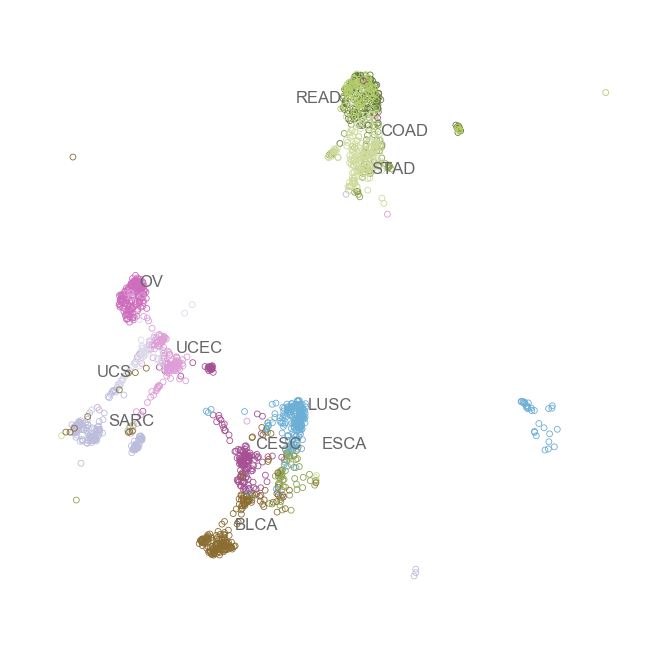

In [916]:
fig, ax = plt.subplots(figsize=(2, 2))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
labels, handles = [], []
xs, ys, texts = [], [], []
for lab, inds in umap_data.groupby('label', sort=False):
    if lab not in ['STAD', 'READ', 'COAD', 'ESCA',
                   'LUSC', 'CESC', 'BLCA', 'ESCA',
                   'OV', 'SARC', 'UCS', 'UCEC']: continue
    scat = ax.scatter(inds['x'], inds['y'], edgecolors=inds['hue'], s=2,
                      lw=0.2, alpha=1, facecolors='none')
    cx = inds['x'].median()
    cy = inds['y'].median()
    xs.append(cx)
    ys.append(cy)
    texts.append(plt.text(cx, cy, lab, size=TICK_TEXT_SIZE, color='0.4'))
    
    #if lab not in labels:
    #    labels.append(lab)
    #    handles.append(scat)
        
adjust_text(texts, xs, ys, expand_points=(1.5, 1.5), force_points=1)

#leg = Legend(ax, handles, labels, ncol=2, bbox_to_anchor=(1.05, 1))
#for handle in leg.legendHandles:
#    handle._sizes = [30]
#    handle._facecolors = handle._edgecolors
#ax.add_artist(leg)
fix_spines(ax, [])
ax.set_ylim(-5, ax.get_ylim()[1])
fig.savefig(output_dir + '/fig_3.5_v5.png', dpi=300)

# Figure 4 - External Validation

In [79]:
def setup_fig3():
    fig = plt.figure(figsize=(FIG_WIDTH_2COL, 6))

    gs = plt.GridSpec(2, 3, width_ratios=[1,1,1], height_ratios=[1.5,1],
                      hspace=0.7, wspace=0.9)
    
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[1, 2])
    
    ax1.axis('off')
    fix_spines(ax2, ['left', 'bottom'], sep=0)
    fix_spines(ax3, ['left', 'bottom'], sep=0)
    fix_spines(ax4, ['left', 'bottom'], sep=0)
    fix_spines(ax5, ['left', 'bottom'], sep=0)
    label_panels((ax1, ax2, ax4, ax3, ax5))
    
    return fig, ax1, ax2, ax3, ax4, ax5

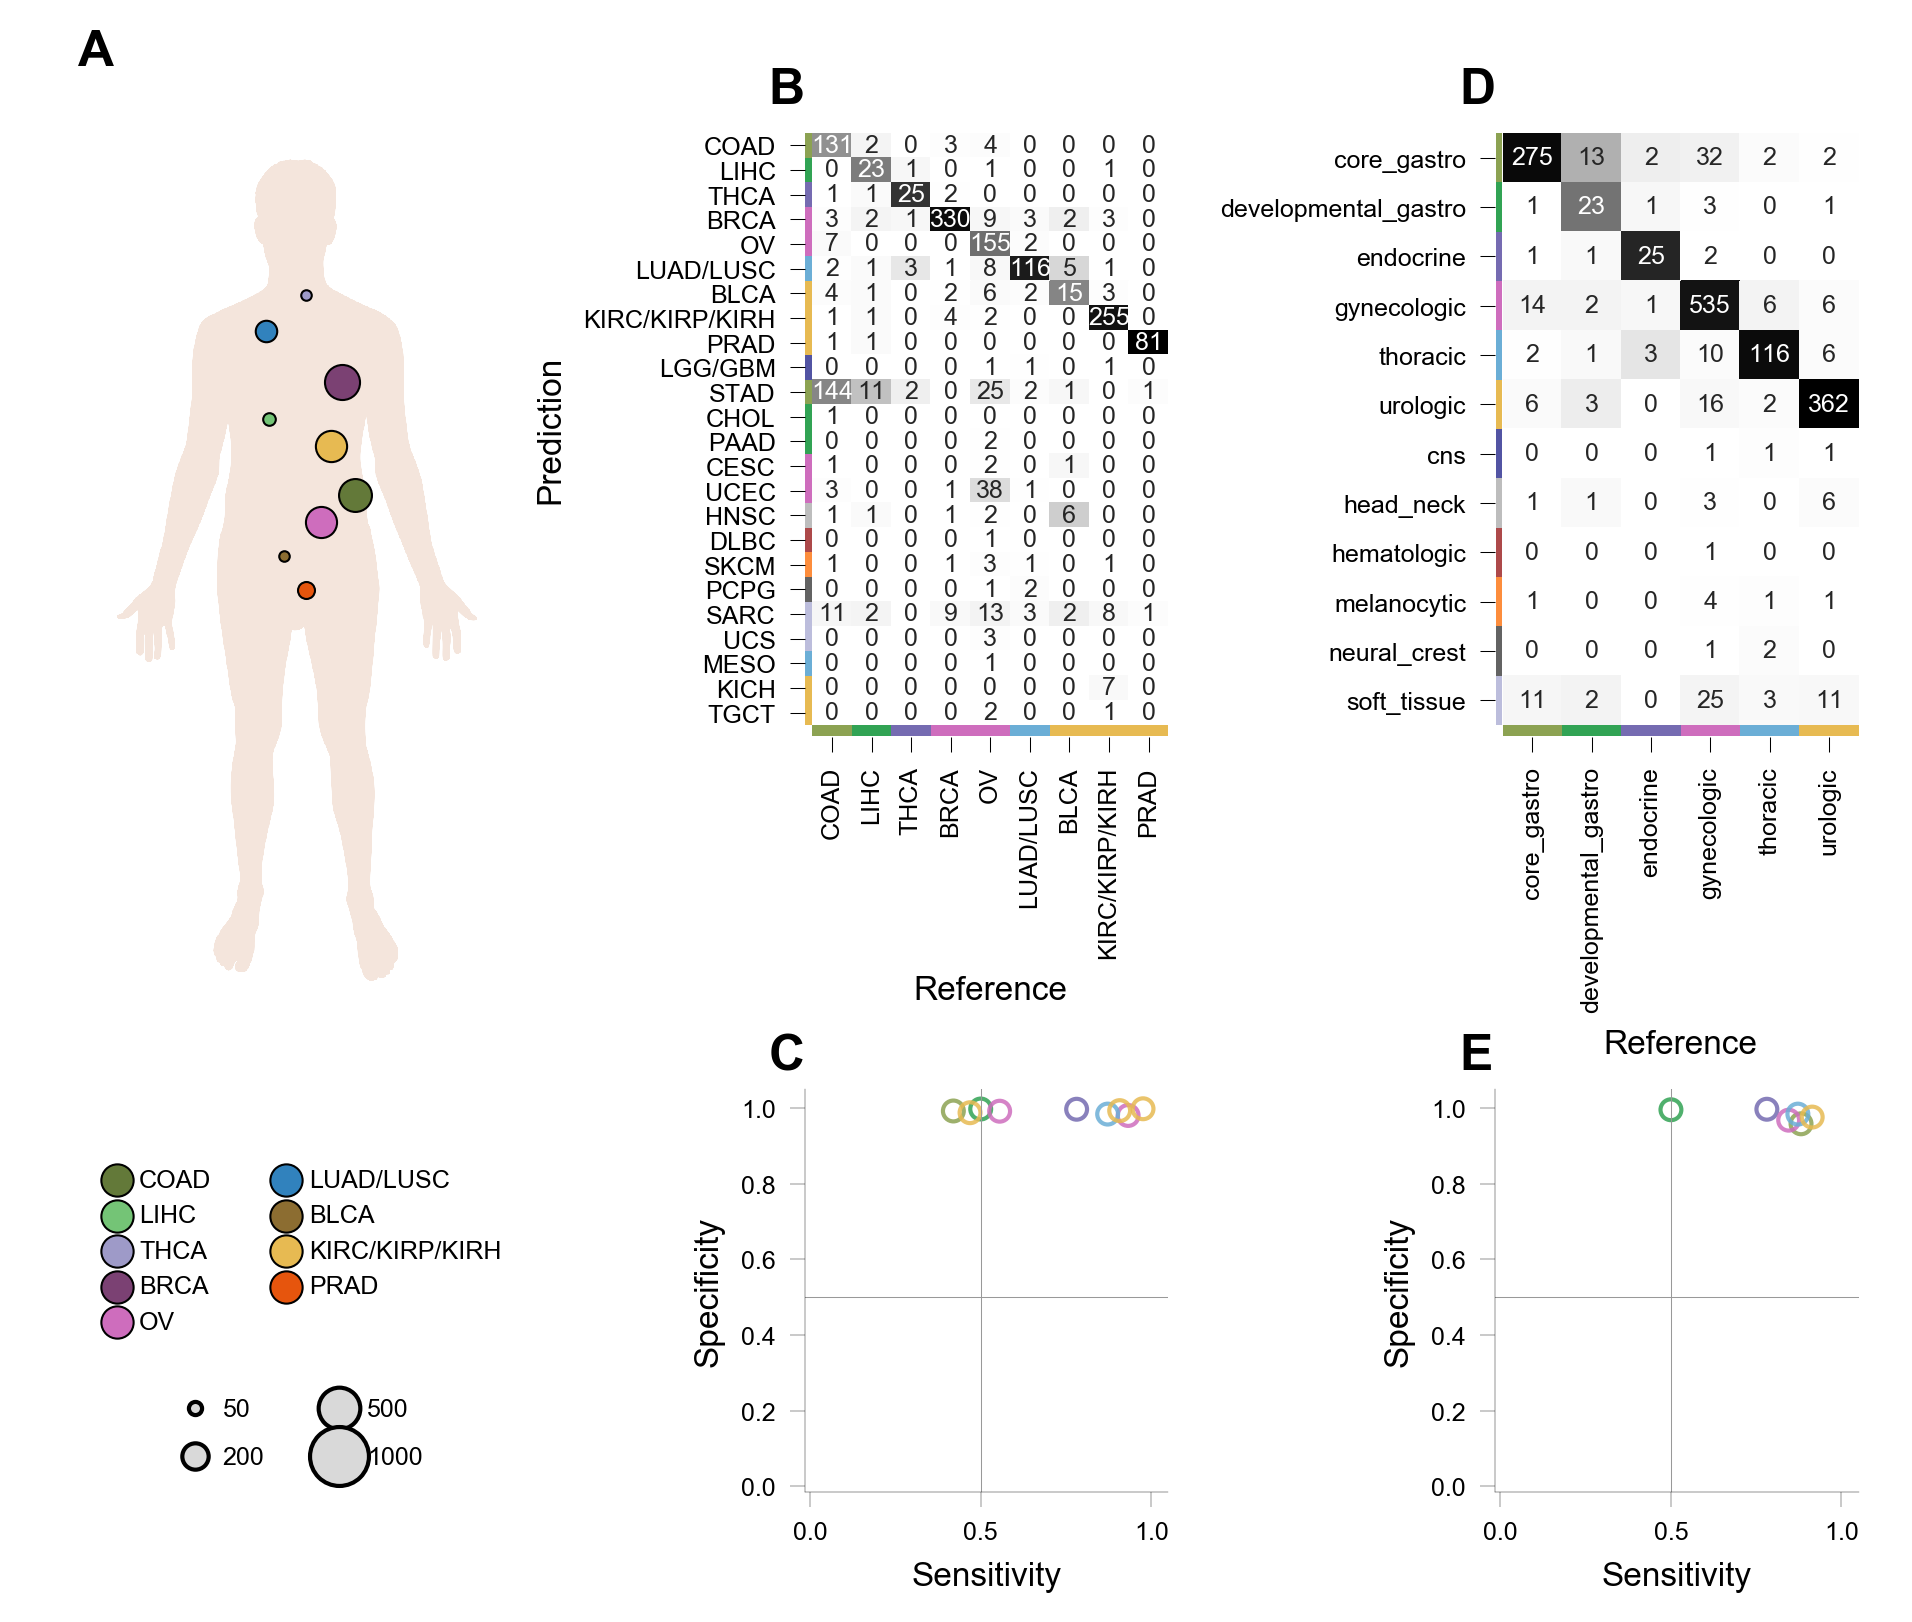

In [316]:
metrics_file = 'cup_project/external_validation/gse2109_metrics.csv'
table_file = 'cup_project/external_validation/gse2109_contingency.csv'

table = read_table(table_file)
table = clean_table(table, blacklist=['LGG/GBM'])
table = sort_rectangular_table(table, primary_data.index)

metrics = read_metrics(metrics_file)
metrics = metrics.loc[table.columns, ['pos pred value', 'sensitivity', 'specificity']]

grouping = primary_data.loc[table.index.union(table.columns),:].groupby('organ_system')
table_group, metrics_group = group_metrics(table, grouping)
table_group = sort_rectangular_table(clean_table(table_group), primary_data.organ_system.unique())

colors_x, colors_y = get_heatmap_colors(table, primary_data, 'shade', other_col=None)
colors_group_x, colors_group_y = get_heatmap_colors(table_group, primary_data, 'shade', other_col='organ_system')

sizes = np.ones(len(colors_x)) * 25
sizes_group = np.ones(len(colors_group_x)) * 25

fig3, anatomy_ax, heatmap_ax1, heatmap_ax2, scatter_ax1, scatter_ax2 = setup_fig3()

subset = ['COAD', 'LIHC', 'THCA', 'BRCA', 'OV', 'LUAD/LUSC', 'BLCA', 
          'KIRC/KIRP/KIRH', 'PRAD']
human_data = primary_data.loc[subset,:]
human_data['n_samples'] = table.sum(axis=0)

anatomical_plot(anatomy_ax, human_data, scaling=0.2,
                size_legend_cols=2, legend_cols=2, colorby='hue')
anatomy_ax.set_ylim(3500, 0)

annotated_heatmap(heatmap_ax1, table, colors_x, colors_y)
annotated_heatmap(heatmap_ax2, table_group, colors_group_x, colors_group_y, show_ylabel=False)

metrics_scatter(scatter_ax1, metrics, colors_x, sizes, show_legend=False,
                metrics=['sensitivity', 'specificity'])
metrics_scatter(scatter_ax2, metrics_group, colors_group_x, sizes_group, show_legend=False, 
                metrics=['sensitivity', 'specificity'])

fig3.savefig(output_dir + '/fig_4_v5.png', dpi=300)

In [75]:
metrics.median(), metrics_group.median(), table.sum().sum()

(pos pred value    0.934844
 sensitivity       0.781250
 specificity       0.992777
 dtype: float64, pos pred value    0.852814
 sensitivity       0.858681
 specificity       0.980570
 dtype: float64, 1552)

In [104]:
table = read_table('cup_project/external_validation/gse2109_contingency.csv')
table.sum(axis=0).sort_index()

BLCA               32
BRCA              354
CESC                0
CHOL                0
COAD              312
DLBC                0
HNSC                0
KICH                0
KIRC/KIRP/KIRH    281
LGG/GBM             6
LIHC               46
LUAD/LUSC         133
MESO                0
OV                279
PAAD                0
PCPG                0
PRAD               83
SARC                0
SKCM                0
STAD                0
TGCT                0
THCA               32
UCEC                0
UCS                 0
dtype: int64

# Figure 5 - Metastasis

In [88]:
def setup_fig4():
    fig = plt.figure(figsize=(FIG_WIDTH_2COL, 7))

    gs = plt.GridSpec(2, 3, width_ratios=[1,1,1.3], height_ratios=[2,1],
                      hspace=0.4, wspace=0.9)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, 0])
    ax5 = fig.add_subplot(gs[1, 1])
    ax6 = fig.add_subplot(gs[1, 2])
    
    ax3.axis('off')
    fix_spines(ax1, ['left', 'bottom'], sep=0)
    fix_spines(ax2, ['left', 'bottom'], sep=0)
    fix_spines(ax4, ['left', 'bottom'], sep=0)
    fix_spines(ax5, ['left', 'bottom'], sep=0)
    fix_spines(ax6, ['bottom'], sep=0)
    label_panels((ax1, ax4, ax2, ax5, ax3, ax6))
    
    return fig, ax3, ax6, ax1, ax2, ax4, ax5

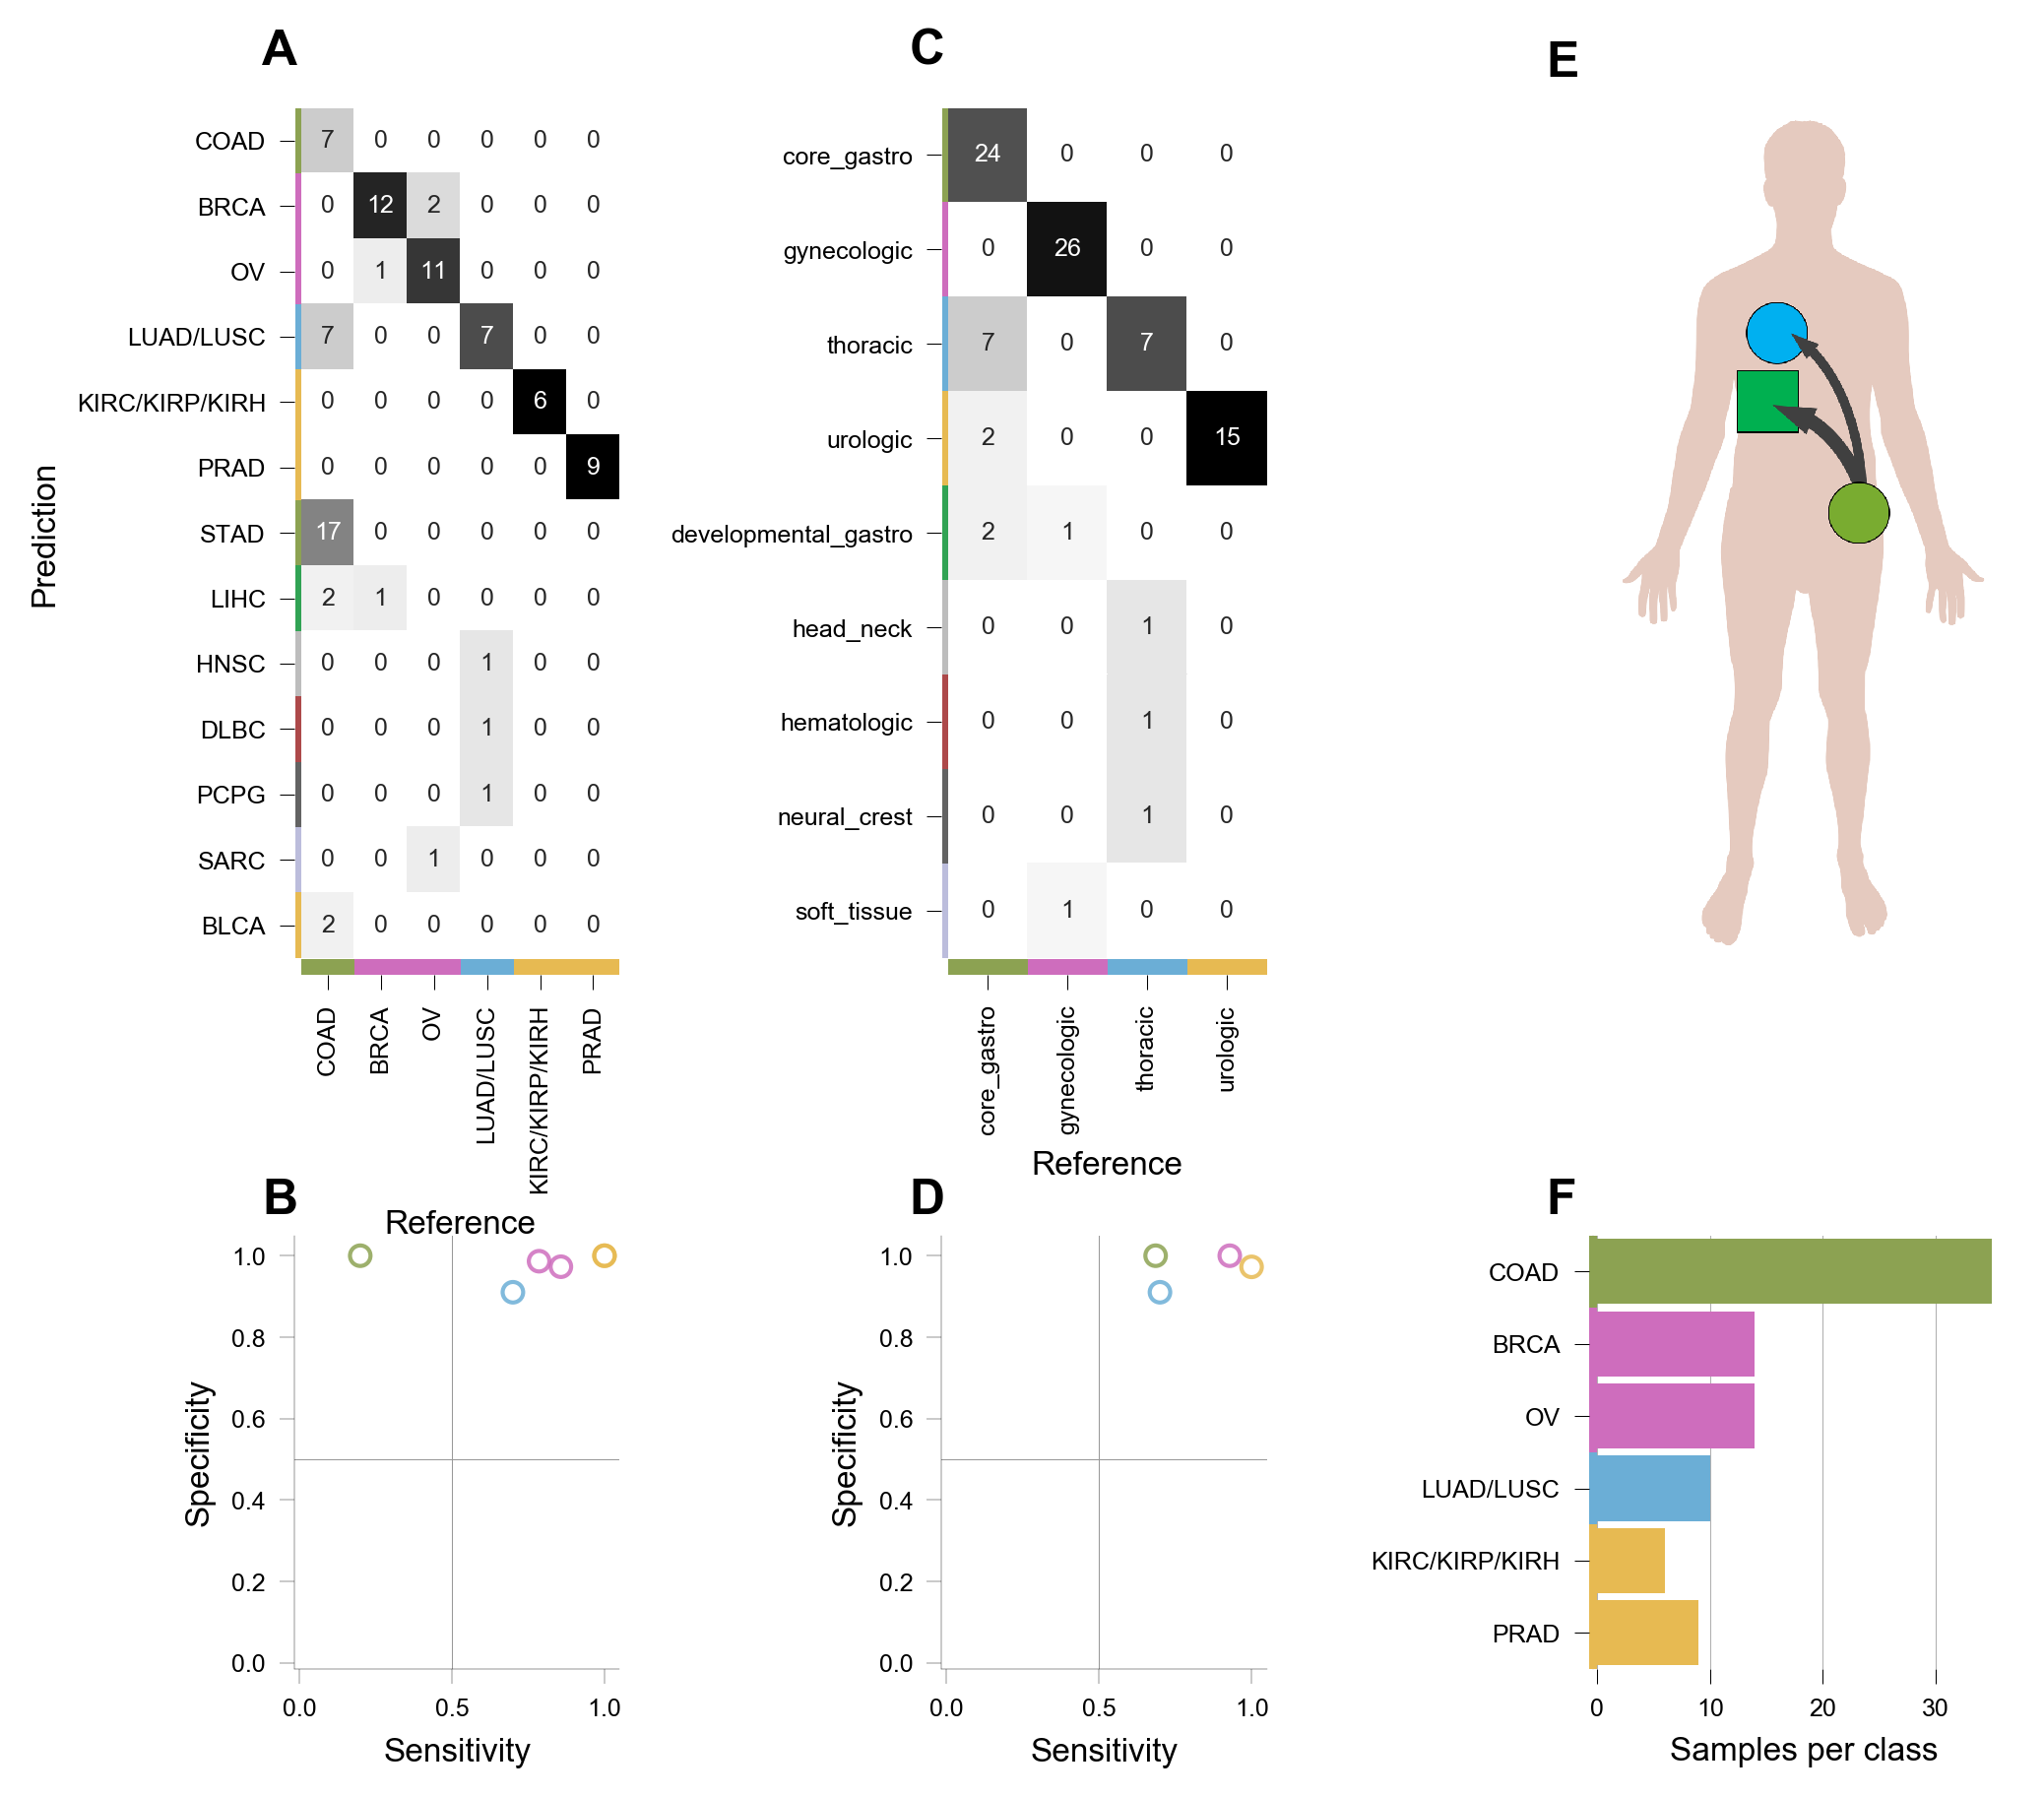

In [317]:
metrics_file = 'cup_project/external_validation/gse18549_metrics.csv'
table_file = 'cup_project/external_validation/gse18549_contingency.csv'
schematic_file = '../../../tcga_paper/metastasis_schematic_simple_v2.tiff'

table = read_table(table_file)
table = clean_table(table, blacklist=[])
table = sort_rectangular_table(table, primary_data.index)

metrics = read_metrics(metrics_file)
metrics = metrics.loc[table.columns, :]#, ['pos pred value', 'sensitivity']]

grouping = primary_data.loc[table.index.union(table.columns),:].groupby('organ_system')
table_group, metrics_group = group_metrics(table, grouping)
table_group = sort_rectangular_table(clean_table(table_group), primary_data.organ_system.unique())

colors_x, colors_y = get_heatmap_colors(table, primary_data, 'shade', other_col=None)
colors_group_x, colors_group_y = get_heatmap_colors(table_group, primary_data, 'shade', other_col='organ_system')

sizes = np.ones(len(colors_x)) * 25
sizes_group = np.ones(len(colors_group_x)) * 25

fig4, anatomy_ax, extra_ax, heatmap_ax1, heatmap_ax2, scatter_ax1, scatter_ax2 = setup_fig4()

subset=['COAD', 'BRCA', 'OV', 'LUAD/LUSC', 'KIRC/KIRP/KIRH', 'PRAD']
human_data = primary_data.loc[subset,:]
human_data['n_samples'] = table.sum(axis=0)

freqs = tumor_data_gse18549['path'].value_counts()
paths = freqs[freqs > 1].index
widths = freqs[freqs > 1].values

#links = []
#subset = []
#for path in paths:
#    width = freqs.loc[path]
#    row = tumor_data_gse18549.loc[tumor_data_gse18549.path == path,:].head(1)
#    subset.append(row.primary.values[0])
#    links.append((row.primary.values[0], 
#                  (row.tumor_coords_x.values[0], row.tumor_coords_y.values[0]), 
#                  width))
#anatomical_plot(anatomy_ax, primary_data, subset=subset, links=links, sizeby=50, 
#                colorby='shade', legend_cols=1, size_legend_cols=1, show_legend=False)

#anatomical_plot(anatomy_ax, human_data, scaling=0.2,
#                size_legend_cols=2, legend_cols=2, colorby='hue')
#anatomy_ax.set_ylim(3500, 0)
anatomy_ax.imshow(plt.imread(schematic_file))

gse18549_labels.classification.value_counts().plot(ax=extra_ax, kind='barh', color='0.3')
extra_ax.set_xlabel('Number of classifications')
extra_ax.invert_yaxis()

annotated_heatmap(heatmap_ax1, table, colors_x, colors_y, show_ylabel=True)
annotated_heatmap(heatmap_ax2, table_group, colors_group_x, colors_group_y, show_ylabel=False)

metrics_scatter(scatter_ax1, metrics, colors_x, sizes, show_legend=False,
                metrics=['sensitivity', 'specificity'])
metrics_scatter(scatter_ax2, metrics_group, colors_group_x, sizes_group, show_legend=False,
                metrics=['sensitivity', 'specificity'])

barplot(extra_ax, table.sum(axis=0), colors_x, colors_x, table.sum(axis=0).index, 'Samples per class')
fig4.savefig(output_dir + '/fig_5_v5.png', dpi=300)

In [217]:
metrics_group.median(), metrics_group.min(), table.sum().sum()
metrics.median(), metrics.min()

(sensitivity             0.821429
 specificity             0.993243
 pos pred value          0.958333
 neg pred value          0.966750
 precision               0.958333
 recall                  0.821429
 f1                      0.851648
 prevalence              0.136364
 detection rate          0.090909
 detection prevalence    0.119318
 balanced accuracy       0.900579
 dtype: float64, sensitivity             0.200000
 specificity             0.910256
 pos pred value          0.500000
 neg pred value          0.654321
 precision               0.500000
 recall                  0.200000
 f1                      0.333333
 prevalence              0.068182
 detection rate          0.068182
 detection prevalence    0.068182
 balanced accuracy       0.600000
 dtype: float64)

In [45]:
gse18549_labels = read_table('cup_project/external_validation/gse18549_sampleid_predictedLabl_trueLabel.csv')
gse18549_labels = gse18549_labels[~gse18549_labels['true.label'].isnull()]
print(gse18549_labels.shape)
gse18549_labels = gse18549_labels.set_index('sampleid').join(tumor_data_gse18549)
inds_correct = (gse18549_labels['predicted.label'] == gse18549_labels['true.label'])
inds_correct_group = (primary_data.loc[gse18549_labels['predicted.label'], 'organ_system'].values ==\
                      primary_data.loc[gse18549_labels['true.label'], 'organ_system'].values)
inds_wrong_tumor = (gse18549_labels['predicted.label'] == gse18549_labels['tumor'])
inds_wrong_other = (gse18549_labels['predicted.label'] != gse18549_labels['tumor']) &\
                    (gse18549_labels['predicted.label'] != gse18549_labels['true.label'])

gse18549_labels.loc[inds_wrong_other, 'classification'] = 'other'
gse18549_labels.loc[inds_wrong_tumor, 'classification'] = 'metastasis'
gse18549_labels.loc[inds_correct_group, 'classification'] = 'primary origin group'
gse18549_labels.loc[inds_correct, 'classification'] = 'primary origin'

(89, 3)


In [28]:
gse18549_labels[gse18549_labels['true.label'].isnull()]

,predicted.label,true.label,primary tumor site:ch1,metastatic tumor site:ch1,path,primary,tumor_coords_x,tumor_coords_y,tumor,classification
sampleid,,,,,,,,,,


In [35]:
gse18549_labels.loc[gse18549_labels.classification == 'other']

,predicted.label,true.label,primary tumor site:ch1,metastatic tumor site:ch1,path,primary,tumor_coords_x,tumor_coords_y,tumor,classification
sampleid,,,,,,,,,,
GSM461738,SARC,OV,Ovary,Omentum,Ovary-->Omentum,OV,420.000000,850.000000,other,other
GSM461741,SARC,OV,Ovary,Pelvis,Ovary-->Pelvis,OV,375.000000,1200.000000,other,other
GSM461744,LUAD/LUSC,COAD,Colon,Liver,Colon-->Liver,COAD,411.148718,698.716867,LIHC,other
GSM461747,LUAD/LUSC,COAD,Colon,Liver,Colon-->Liver,COAD,411.148718,698.716867,LIHC,other
GSM461761,BLCA,COAD,Colon,Liver,Colon-->Liver,COAD,411.148718,698.716867,LIHC,other
GSM461778,LUAD/LUSC,COAD,Colon,Liver,Colon-->Liver,COAD,411.148718,698.716867,LIHC,other
GSM461785,LUAD/LUSC,COAD,Colon adenocarcinoma,Brain,Colon adenocarcinoma-->Brain,COAD,514.943590,88.777108,LGG,other
GSM461790,HNSC,LUAD/LUSC,Lung adenocarcinoma,Brain,Lung adenocarcinoma-->Brain,LUAD,514.943590,88.777108,LGG,other
GSM461794,PCPG,LUAD/LUSC,Lung,Brain,Lung-->Brain,LUAD,514.943590,88.777108,LGG,other


In [646]:
import sklearn.metrics as skmetrics
print(skmetrics.confusion_matrix(gse18549_labels['true.label'], gse18549_labels['predicted.label']).diagonal().sum())
print(sorted(set(gse18549_labels['true.label']) | set(gse18549_labels['predicted.label'])))

[ 0 12  8  0  0  6  0  7 11  0  9  0  0  0]
['BLCA', 'BRCA', 'COAD', 'DLBC', 'HNSC', 'KIRC/KIRP/KIRH', 'LIHC', 'LUAD/LUSC', 'OV', 'PCPG', 'PRAD', 'READ', 'SARC', 'STAD']


In [51]:
gse18549_labels.loc[:, ['path']].apply(
    lambda s: '  '.join(s), axis=1).value_counts()

Colon-->Liver                             25
Prostate-->Bone                            9
Ovary-->Omentum                            9
Breast-->Lymph Node                        7
Colon-->Lung                               5
Breast-->Liver                             3
Lung adenocarcinoma-->Brain                3
Lung-->Lymph Node                          3
Lung-->Brain                               3
Breast-->Chest wall                        2
Renal-->Retroperitoneal                    2
Colon-->Colon                              1
Colon-->Ovary                              1
Renal-->Ankle                              1
Breast mucinous adenocarcinoma-->Brain     1
Colon adenocarcinoma-->Brain               1
Ovary-->Rectum                             1
Colon-->Colon, left                        1
Breast carcinoma-->Brain                   1
Rectal-->Lung                              1
Ovary-->Uterus                             1
Ovarian vs Peritoneal-->Omentum            1
Colon-->Co

In [719]:
72/88

0.8181818181818182

Text(0.5,0,'Number of classifications')

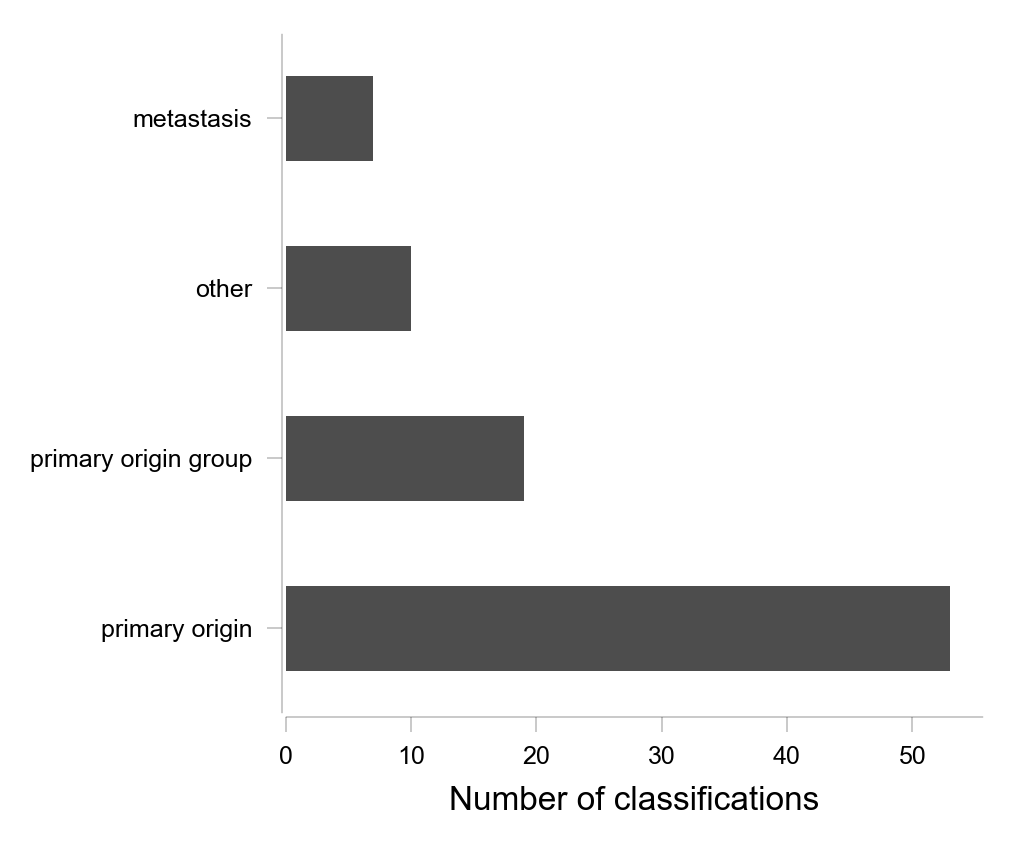

In [707]:
fig, ax = plt.subplots(figsize=(3, 3))
gse18549_labels.classification.value_counts().plot(ax=ax, kind='barh', color='0.3')
fix_spines(ax, ['left', 'bottom'])
ax.set_xlabel('Number of classifications')

# Figure 6 - PDX

In [84]:
def setup_fig5():
    fig = plt.figure(figsize=(FIG_WIDTH_2COL, 6))

    gs = plt.GridSpec(2, 3, width_ratios=[1.5,1,1], height_ratios=[1.5,1],
                      hspace=0.7, wspace=0.9)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax6 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[1, 2])

    
    ax1.axis('off')
    ax1.set_anchor('NW')
    ax1.margins(0, 0, tight=True)
    pos = ax1.get_position()
    yoffset = 0.1666
    xoffset = 0.0666
    ax1.set_position([pos.x0, pos.y0 - yoffset, pos.x1 - pos.x0 + xoffset, pos.y1-pos.y0 + yoffset])
    
    fix_spines(ax6, ['left', 'bottom'], sep=0)
    fix_spines(ax2, ['left', 'bottom'], sep=0)
    fix_spines(ax3, ['left', 'bottom'], sep=0)
    fix_spines(ax4, ['left', 'bottom'], sep=0)
    fix_spines(ax5, ['left', 'bottom'], sep=0)
    label_panels((ax1, ax6, ax2, ax4, ax3, ax5))
    #label_panels((ax2, ax3, ax4, ax5))
    
    return fig, ax1, ax6, ax2, ax3, ax4, ax5
    #return fig, ax1, ax2, ax3, ax4, ax5

dict_keys(['cns', 'core_gastro', 'developmental_gastro', 'endocrine', 'gynecologic', 'head_neck', 'hematologic', 'melanocytic', 'neural_crest', 'soft_tissue', 'thoracic', 'urologic'])


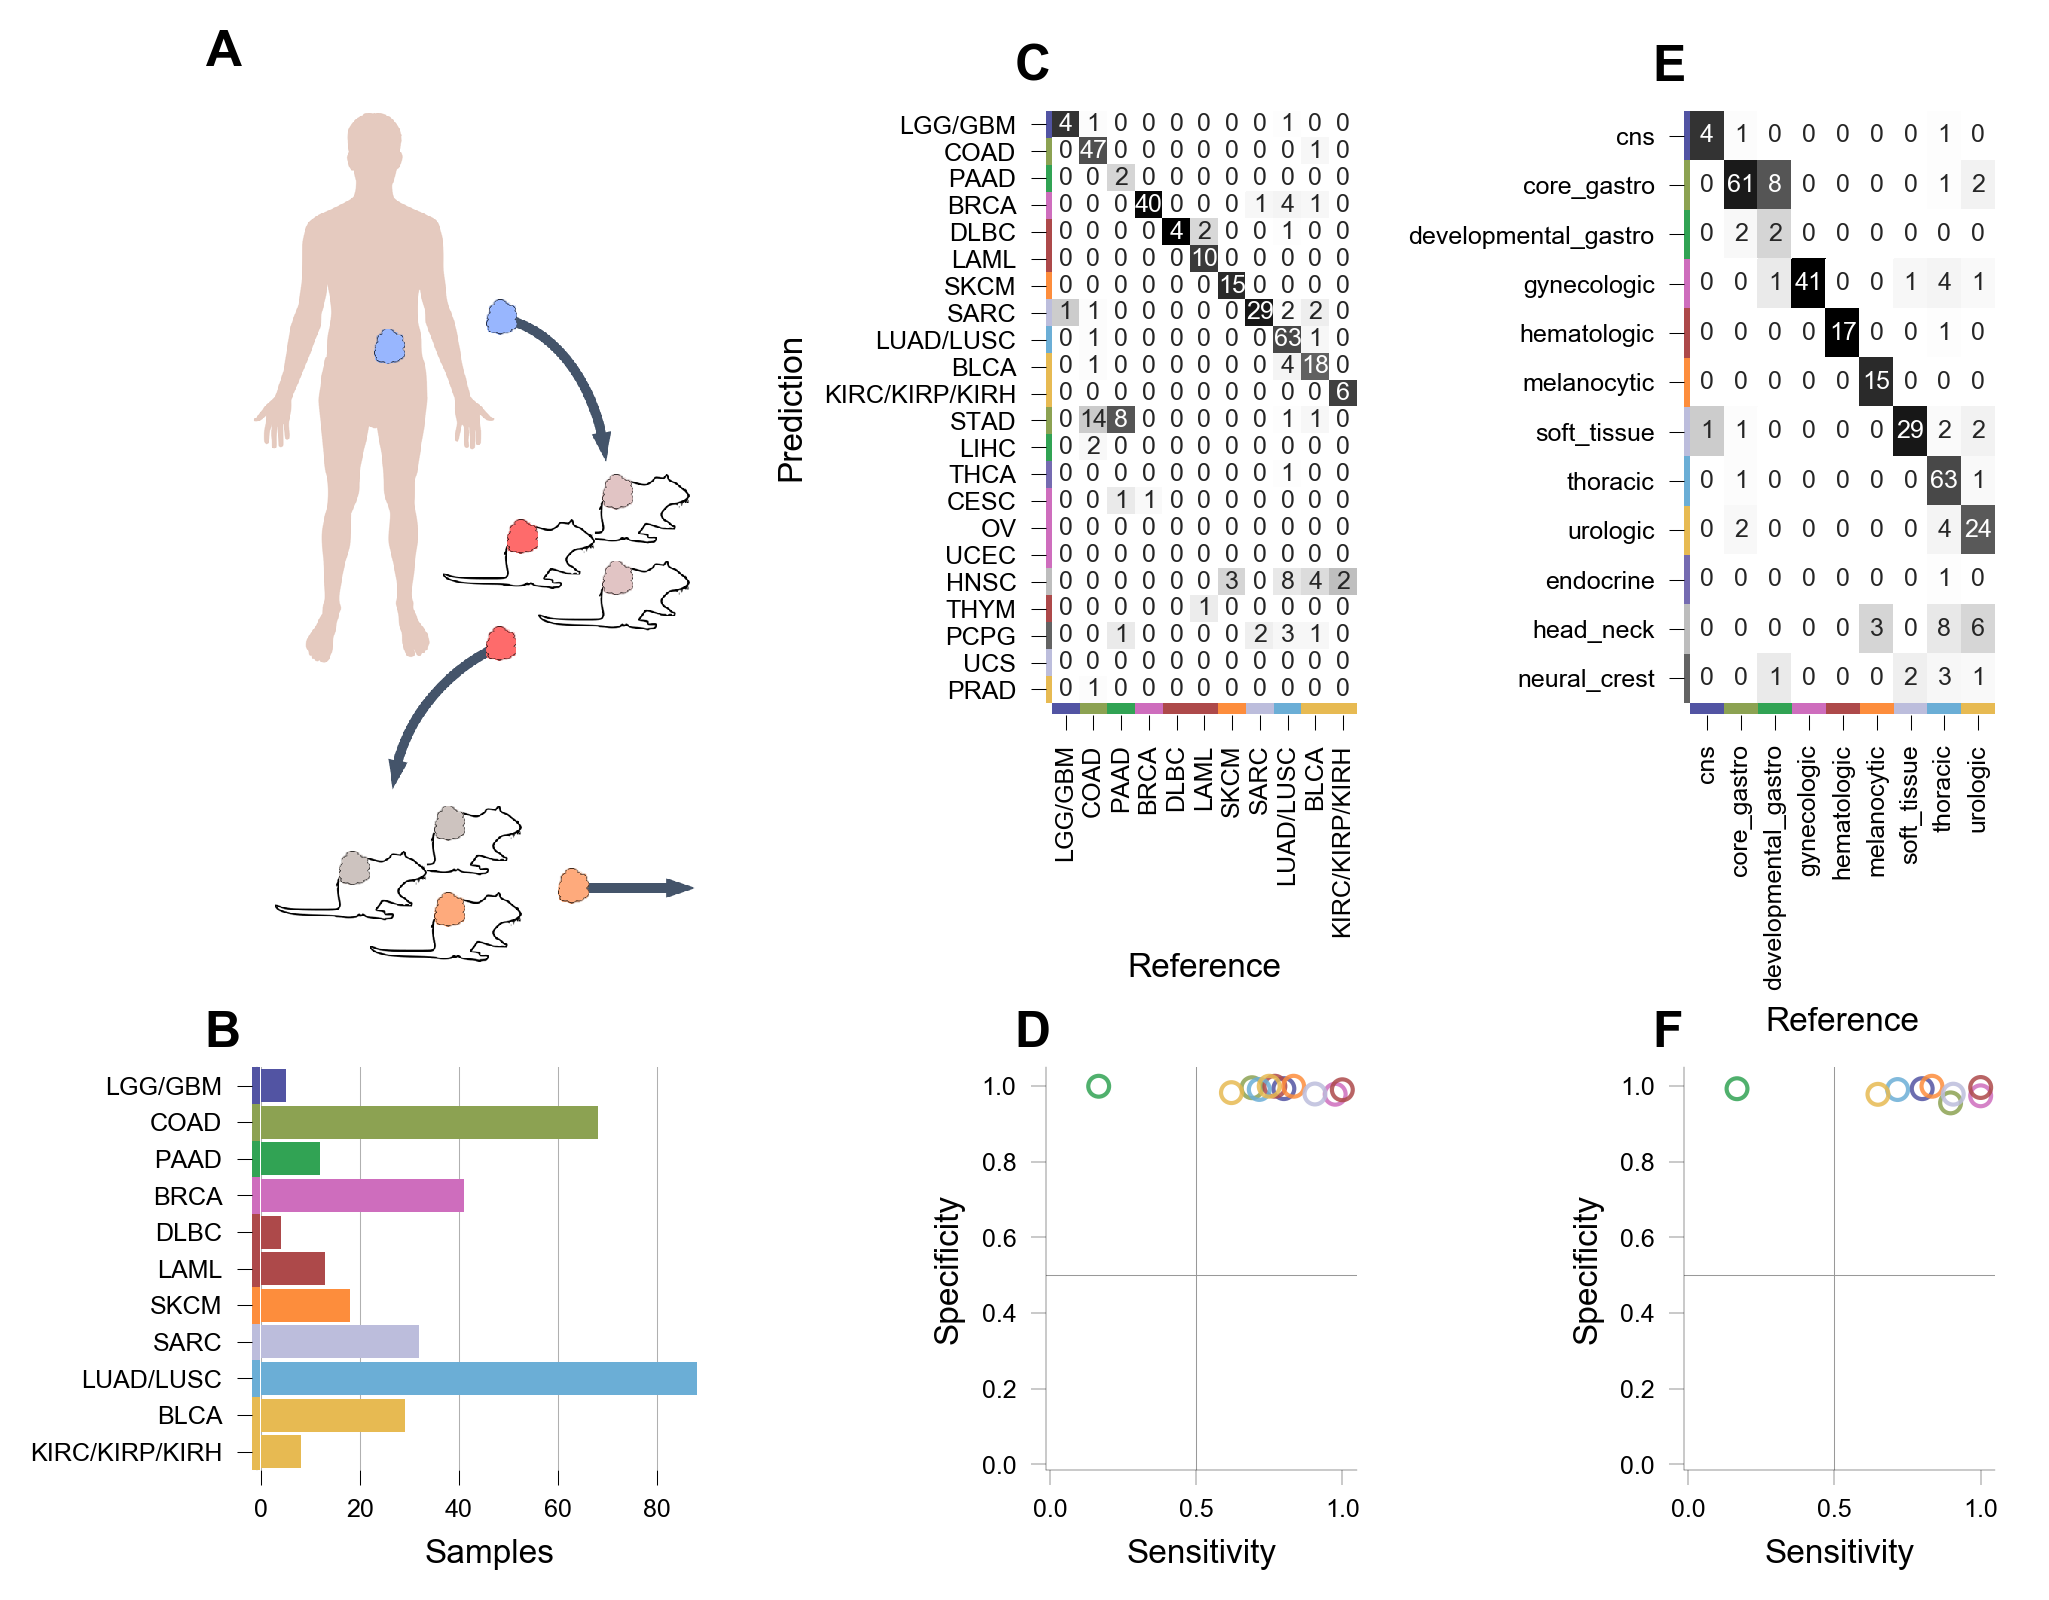

In [318]:
#metrics_file = 'cup_project/external_validation/pdx_metrics.csv'
#table_file = 'cup_project/external_validation/pdx_contingency.csv'
metrics_file = 'cup_project/external_validation/pdx_metrics_new.csv'
table_file = 'cup_project/external_validation/pdx_contingency_new.csv'
pdx_schematic = '../../../tcga_paper/pdx_schematic_2.tiff'

table = read_table(table_file)
table = clean_table(table, blacklist=['OV'])
table = sort_rectangular_table(table, primary_data.index)

metrics = read_metrics(metrics_file)
metrics = metrics.loc[table.columns, :]#, ['pos pred value', 'sensitivity']]

grouping = primary_data.loc[table.index.union(table.columns),:].groupby('organ_system')
print(grouping.groups.keys())
table_group, metrics_group = group_metrics(table, grouping)
table_group = sort_rectangular_table(clean_table(table_group), primary_data.organ_system.unique())

colors_x, colors_y = get_heatmap_colors(table, primary_data, 'shade', other_col=None)
colors_group_x, colors_group_y = get_heatmap_colors(table_group, primary_data, 'shade', other_col='organ_system')

sizes = np.ones(len(colors_x)) * 25
sizes_group = np.ones(len(colors_group_x)) * 25

#fig5, anatomy_ax, heatmap_ax1, heatmap_ax2, scatter_ax1, scatter_ax2 = setup_fig5()
fig5, image_ax, bar_ax, heatmap_ax1, heatmap_ax2, scatter_ax1, scatter_ax2 = setup_fig5()

image_ax.imshow(plt.imread(pdx_schematic), aspect='equal')
barplot(bar_ax, table.sum(axis=0), colors_x, colors_x, table.columns, 'Samples')

annotated_heatmap(heatmap_ax1, table, colors_x, colors_y)
annotated_heatmap(heatmap_ax2, table_group, colors_group_x, colors_group_y, show_ylabel=False)

metrics_scatter(scatter_ax1, metrics, colors_x, sizes, show_legend=False,
                metrics=['sensitivity', 'specificity'])
metrics_scatter(scatter_ax2, metrics_group, colors_group_x, sizes_group, show_legend=False,
                metrics=['sensitivity', 'specificity'])

fig5.savefig(output_dir + '/fig_6_v5-full.png', dpi=300)

In [731]:
metrics.median(), metrics_group.median()

(sensitivity             0.769231
 specificity             0.995726
 pos pred value          0.970149
 neg pred value          0.989726
 precision               0.970149
 recall                  0.769231
 f1                      0.820513
 prevalence              0.043046
 detection rate          0.033113
 detection prevalence    0.049669
 balanced accuracy       0.884615
 dtype: float64, pos pred value    0.859155
 sensitivity       0.833333
 specificity       0.990338
 dtype: float64)

In [201]:
table = read_table('cup_project/external_validation/pdx_contingency_new.csv')
table.sum(axis=0).sort_index()
table.sum().sum()# + 13

325

# Figure 7 - Subtype classification

In [311]:
def setup_fig7():
    fig, axarr = plt.subplots(2, 1, figsize=(FIG_WIDTH_2COL, 7),
                              gridspec_kw=dict(height_ratios=[2, 1]))
    fig.subplots_adjust(hspace=0.4)
    
    [ax.set_axis_off() for ax in axarr.flatten()]
    gs1 = GridSpecFromSubplotSpec(1, 4, subplot_spec=axarr[0], wspace=0.3)
    gs2 = GridSpecFromSubplotSpec(1, 4, subplot_spec=axarr[1], wspace=0.9)
    
    ax1, ax2, ax3, ax4 = [fig.add_subplot(gs1[k]) for k in range(4)]
    ax5, ax6, ax7, ax8 = [fig.add_subplot(gs2[k]) for k in range(4)]
    axs = (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8)

    pos = ax6.get_position()
    xoffset0 = -0.04
    xoffset1 = -0.00
    ax6.set_position([pos.x0 + xoffset0, pos.y0, pos.x1 - pos.x0 + xoffset1, pos.y1-pos.y0])
    
    pos = ax7.get_position()
    xoffset = 0.02
    ax7.set_position([pos.x0 + xoffset, pos.y0, pos.x1 - pos.x0 + xoffset, pos.y1-pos.y0])
    
    for ax in axs:
        fix_spines(ax, ['left', 'bottom'], sep=0)

    label_panels(axs)
    
    return (fig,) + axs

In [312]:
subtype_directory = 'cup_project/subtype/'
subtype_data = load_subtype_metrics(subtype_directory)
subtype_data.drop(labels=['NF1'], axis=0, inplace=True)
subtype_data['shade'] = primary_data.loc[subtype_data.primary_type, 'hue'].values

hues = []
for k, group in subtype_data.groupby('primary_type'):
    hues += list(map(rgb2hex, desaturate(group.shade[0], len(group))))
subtype_data['hue'] = hues

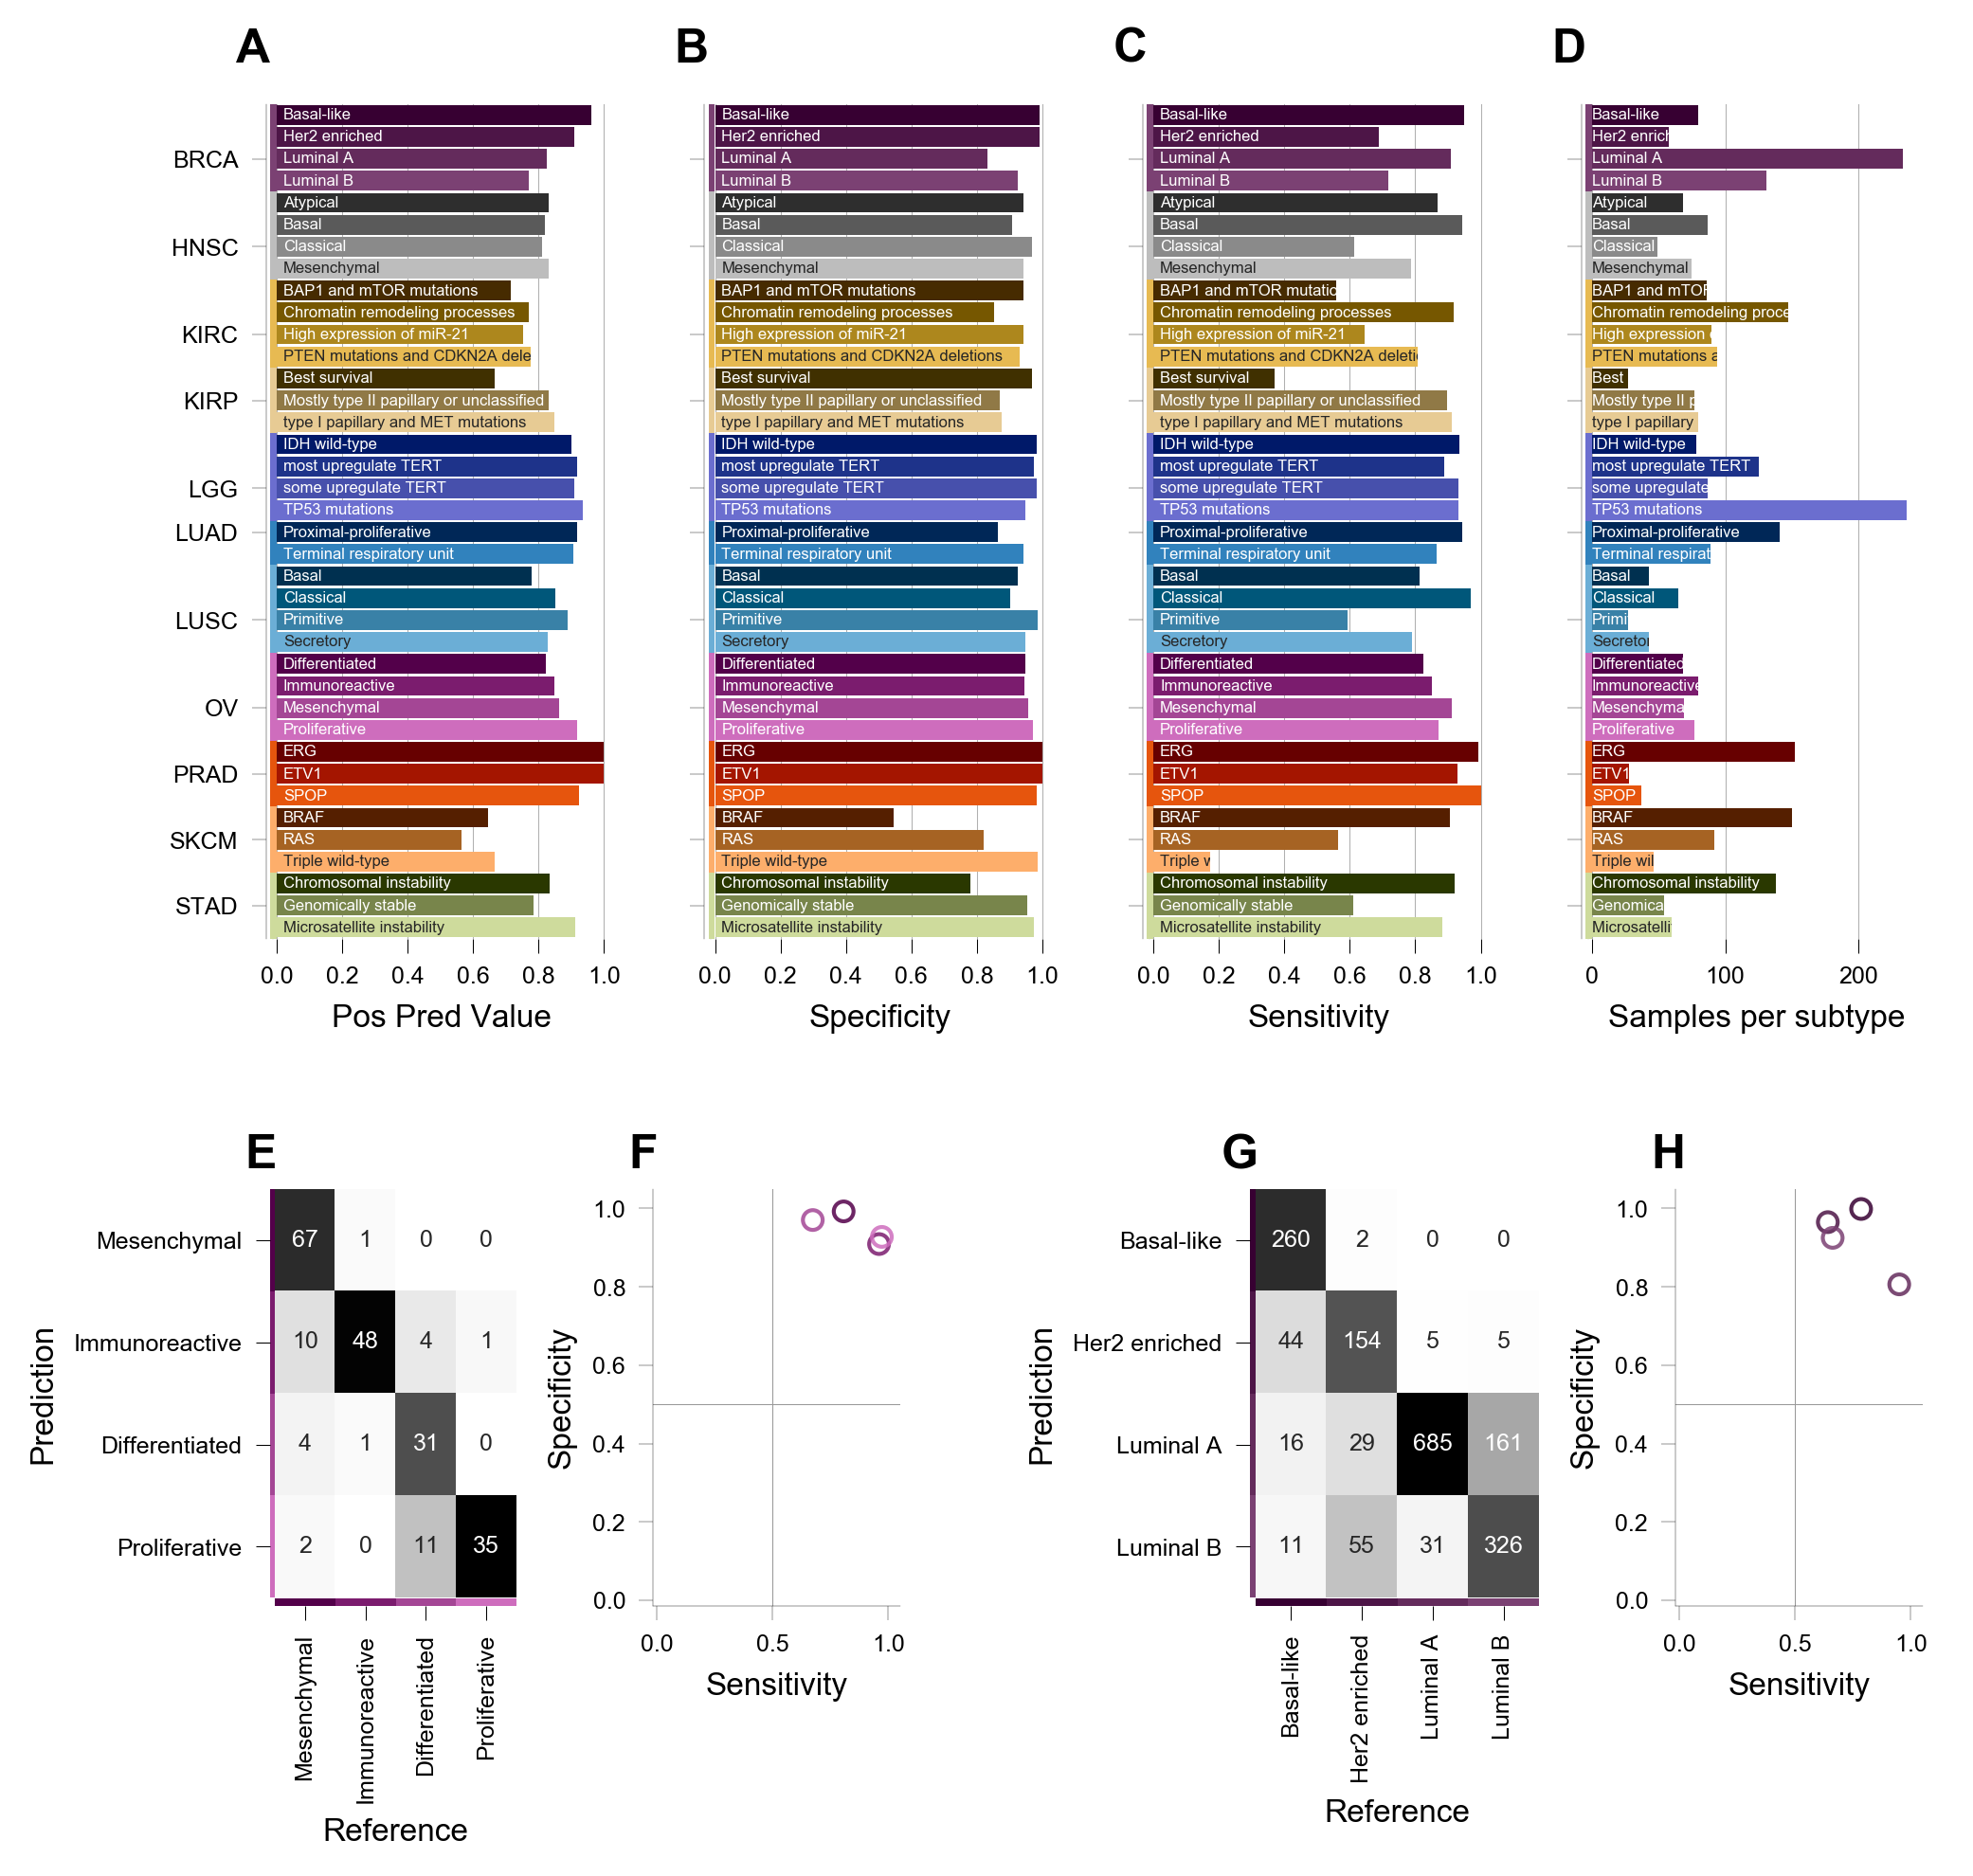

In [319]:
fig6, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = setup_fig7()

pos_pred_value = subtype_data['pos pred value']
sensitivity = subtype_data['sensitivity']
specificity = subtype_data['specificity']
n_samples = subtype_data['n_samples']

ovarian_table = 'cup_project/external_validation_subtype/ovarian_aocs_contingency.csv'
ovarian_metrics = 'cup_project/external_validation_subtype/ovarian_aocs_metrics.csv'
breast_table = 'cup_project/external_validation_subtype/breast_contingency.csv'
breast_metrics = 'cup_project/external_validation_subtype/breast_metrics.csv'

ovarian_table = clean_table(read_table(ovarian_table))
breast_table = clean_table(read_table(breast_table))

ovarian_colors = desaturate(primary_data.loc['OV', 'hue'], 4)
breast_colors = desaturate(primary_data.loc['BRCA', 'hue'], 4)


#for ax, data, label in zip((ax1, ax2, ax3), (sensitivity, specificity, n_samples),
#                           ('Sensitivity', 'Specificity', 'Samples per subtype')):
for ax, data, label in zip((ax1, ax2, ax3, ax4), (pos_pred_value, specificity, sensitivity, n_samples),
                           ('Pos Pred Value', 'Specificity', 'Sensitivity', 'Samples per subtype')):
    subtype_combined_barplot(ax, data, subtype_data['hue'], subtype_data['shade'], 
                             subtype_data.primary_type, subtype_data.index, label, bar_text=True,
                             show_ylabels=bool(label == 'Pos Pred Value'))

annotated_heatmap(ax5, ovarian_table, ovarian_colors, ovarian_colors)
annotated_heatmap(ax7, breast_table, breast_colors, breast_colors)
ovarian_metrics = _construct_metrics(ovarian_table)
breast_metrics = _construct_metrics(breast_table)

metrics_scatter(ax6, ovarian_metrics, ovarian_colors, np.ones(4)*25, show_legend=False,
                metrics=['sensitivity', 'specificity'])
metrics_scatter(ax8, breast_metrics, breast_colors, np.ones(4)*25, show_legend=False,
                metrics=['sensitivity', 'specificity'])

fig6.savefig(output_dir + '/fig_7_v5.png', dpi=300)

In [219]:
pd.concat((breast_metrics, ovarian_metrics)).median()

pos pred value    0.769742
sensitivity       0.796364
specificity       0.946200
dtype: float64

In [220]:
sensitivity.median(), specificity.median()
#subtype_data.groupby('primary_type')['sensitivity'].median()

(0.8767316017316015, 0.9454139442560585)

In [202]:
breast_table.sum().sum() + ovarian_table.sum().sum()
#n_samples.sum()

1999

In [221]:
ovarian_metrics.median(), breast_metrics.median()

(pos pred value    0.811508
 sensitivity       0.883614
 specificity       0.948894
 dtype: float64, pos pred value    0.769742
 sensitivity       0.724050
 specificity       0.944974
 dtype: float64)

In [760]:
read_metrics(breast_metrics).sensitivity

Basal-like       0.785498
Her2 enriched    0.641667
Luminal A        0.950069
Luminal B        0.662602
Name: sensitivity, dtype: float64

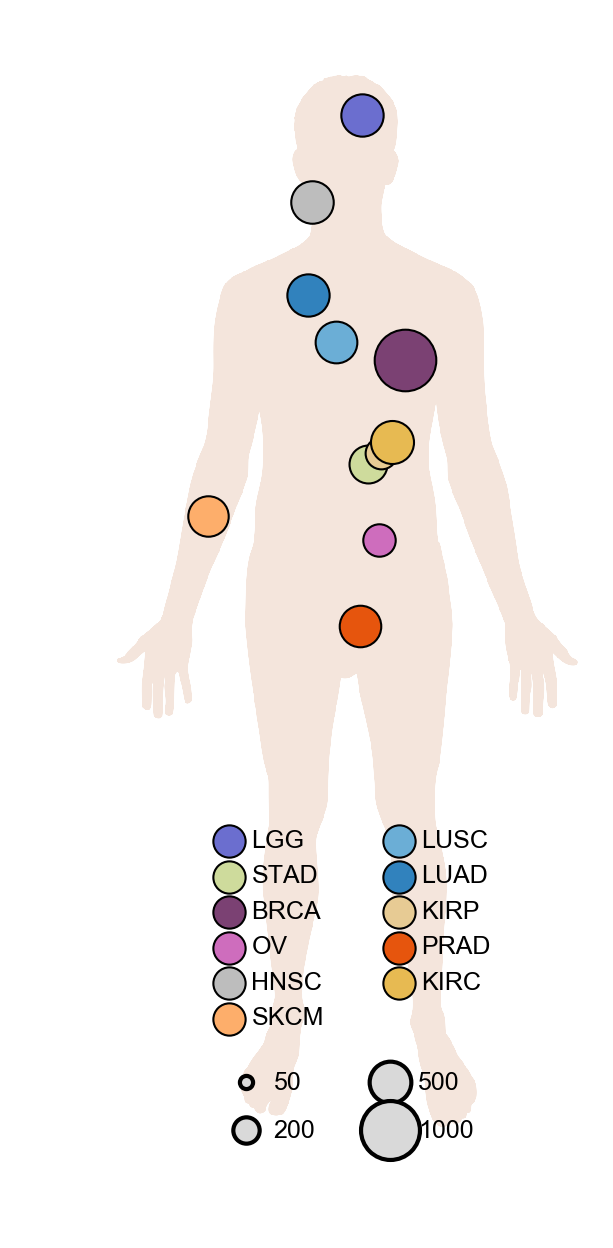

In [501]:
fig, ax = plt.subplots(figsize=(2, 5))
ax.axis('off')

subset = ['BRCA', 'HNSC', 'KIRC', 'KIRP', 'LGG', 'LUAD', 'LUSC', 'OV', 'PRAD', 'SKCM', 'STAD']
human_data = primary_data.loc[subset,:]
human_data['n_samples'] = table.sum(axis=0)

anatomical_plot(ax, primary_data, scaling=0.2, subset=subset,
                size_legend_cols=2, legend_cols=2, colorby='hue')

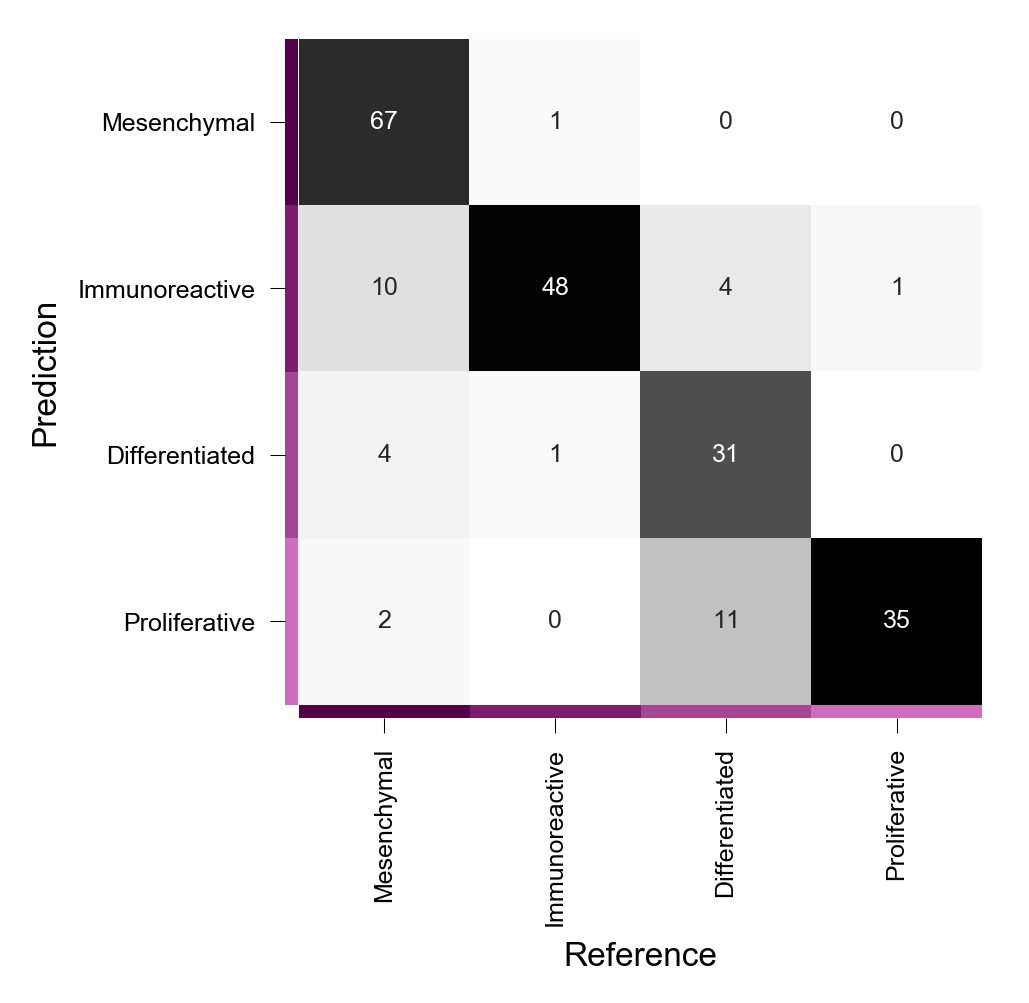

In [459]:
ovarian_table = 'cup_project/external_validation_subtype/ovarian_aocs_contingency.csv'
ovarian_metrics = 'cup_project/external_validation_subtype/ovarian_aocs_metrics.csv'

table = read_table(ovarian_table)

fig, ax = plt.subplots(figsize=(3, 3))

colors = desaturate(primary_data.loc['OV', 'hue'], 4)

annotated_heatmap(ax, table, colors, colors)

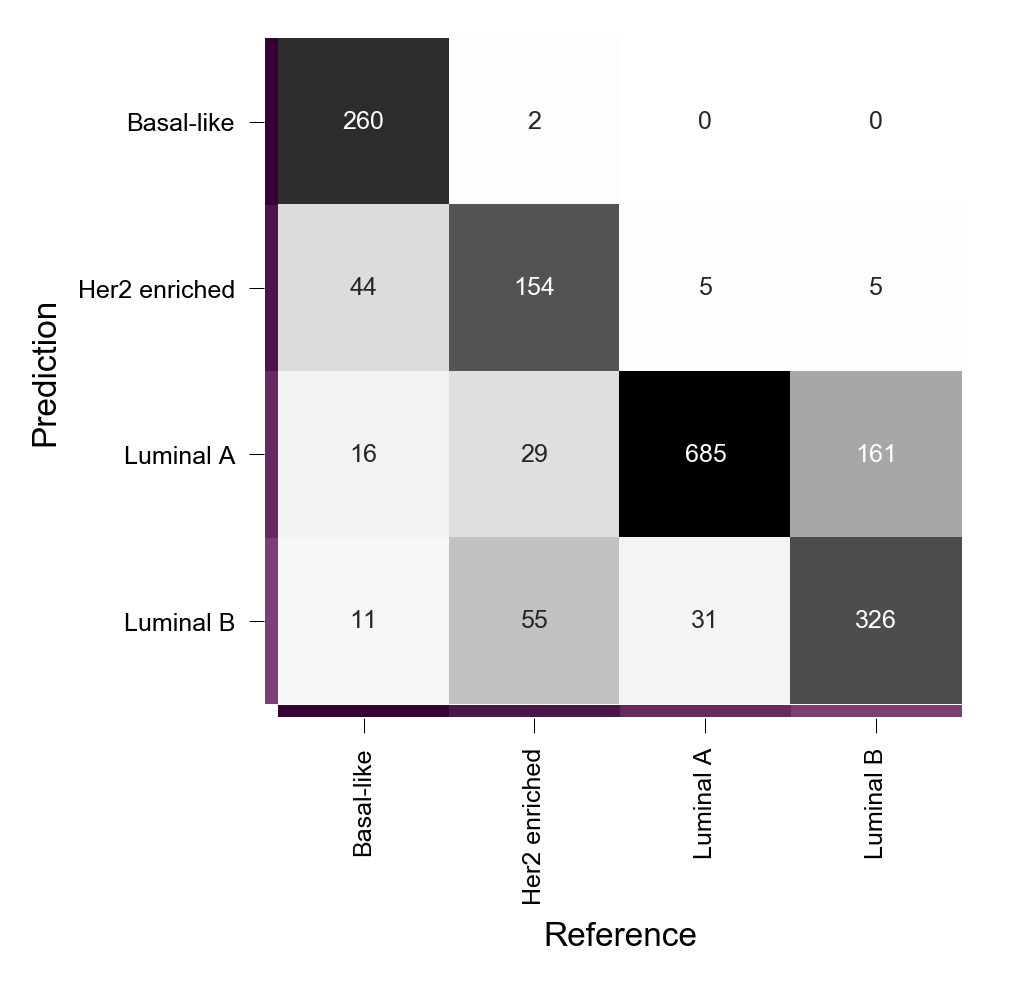

In [387]:
breat_table = 'cup_project/external_validation_subtype/breast_contingency.csv'
breast_metrics = 'cup_project/external_validation_subtype/breast_metrics.csv'

table = read_table(breat_table)

fig, ax = plt.subplots(figsize=(3, 3))

colors = desaturate(primary_data.loc['BRCA', 'hue'], 4)

annotated_heatmap(ax, table, colors, colors)

## Figure 7 - Dimensionality reduction

# Utility code

In [4]:
import string
def label_panels(axs, outside=True, left=True, uppercase=True):
    axarr = np.array(axs)
    
    x = (2*int(outside) - 1) * (2*int(not left)-1) * 0.1 + int(not left)
    y = (2*int(outside) - 1) * 0.05 + 1

    alphabet = string.ascii_uppercase if uppercase else string.ascii_lowercase
    for n, ax in enumerate(axarr.flat):
        ax.text(x, y, alphabet[n], transform=ax.transAxes, 
                weight='bold', fontname='Arial',
                size=PANEL_LABEL_SIZE if outside else PANEL_LABEL_SIZE_SMALL)

In [5]:
def fix_spines(ax, keep_spines=['left', 'bottom'], sep=1, keep_ticks=False, thickness=0.1):
    for loc, spine in ax.spines.items():
        if loc in keep_spines:
            spine.set_position(('outward', sep))
            spine.set_linewidth(thickness)
        else:
            spine.set_color('none')

    params = dict(direction='out', width=thickness)
    if 'left' in keep_spines and 'right' in keep_spines:
        pass
    elif 'left' in keep_spines:
        ax.yaxis.set_ticks_position('left')
        ax.yaxis.set_tick_params(which='both', **params)
    elif 'right' in keep_spines:
        ax.yaxis.set_label_position('right')
        ax.yaxis.set_ticks_position('right')
        ax.yaxis.set_tick_params(which='both', **params)
    else:
        if not keep_ticks:
            ax.yaxis.set_ticks([])

    if 'bottom' in keep_spines and 'top' in keep_spines:
        pass
    elif 'bottom' in keep_spines:
        ax.xaxis.set_ticks_position('bottom')
        ax.xaxis.set_tick_params(which='both', **params)
    elif 'top' in keep_spines:
        ax.xaxis.set_label_position('top')
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_tick_params(which='both' **params)
    else:
        if not keep_ticks:
            ax.xaxis.set_ticks([])

In [6]:
def clear_axes(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

def transfer_ticks(ax1, ax2, which='x', rotation=0):
    if which == 'x':
        getter_ticks = lambda ax: ax.get_xticks()
        getter_tlabels = lambda ax: ax.get_xticklabels()
        getter_labels = lambda ax: ax.get_xlabel()
        getter_lim = lambda ax: ax.get_xlim()
        
        setter_ticks = lambda ax, t: ax.set_xticks(t)
        setter_tlabels = lambda ax, t: ax.set_xticklabels(t, rotation=rotation)
        setter_labels = lambda ax, t: ax.set_xlabel(t)
        setter_lim = lambda ax, t: ax.set_xlim(*t)
    else:
        getter_ticks = lambda ax: ax.get_yticks()
        getter_tlabels = lambda ax: ax.get_yticklabels()
        getter_labels = lambda ax: ax.get_ylabel()
        getter_lim = lambda ax: ax.get_ylim()

        setter_ticks = lambda ax, t: ax.set_yticks(t)
        setter_tlabels = lambda ax, t: ax.set_yticklabels(t, rotation=rotation)
        setter_labels = lambda ax, t: ax.set_ylabel(t)
        setter_lim = lambda ax, t: ax.set_ylim(*t)
        
    clear_axes(ax2)
        
    setter_ticks(ax2, getter_ticks(ax1))
    setter_tlabels(ax2, getter_tlabels(ax1))
    setter_labels(ax2, getter_labels(ax1))
    setter_lim(ax2, getter_lim(ax1))

    setter_ticks(ax1, [])
    setter_tlabels(ax1, [])
    setter_labels(ax1, '')
    #clear_axes(ax1)

In [7]:
def read_table(f):
    return pd.read_csv(f, index_col=0, header=0)

def read_metrics(f):
    metrics = read_table(f)
    metrics.fillna(0, inplace=True)
    metrics.columns = metrics.columns.str.lower()
    metrics.index = metrics.index.str.extract('^Class: (.*)', expand=False)
    return metrics

In [8]:
def clean_table(table, blacklist=[]):
    table = table.fillna(0)
    empty_rows = table.sum(axis=1) < 1e-2
    empty_cols = table.sum(axis=0) < 1e-2
    
    blacklist = table.columns.isin(blacklist)
    empty_cols = empty_cols | blacklist
    
    return table.loc[~empty_rows, ~empty_cols]

In [9]:
def sort_rectangular_table(table, reference_sort):
    reference_sort = pd.Index(reference_sort)
    # sort by reference_sort
    cols = table.columns
    inds = table.index
    table = table.loc[reference_sort[reference_sort.isin(inds)],
                      reference_sort[reference_sort.isin(cols)]]

    cols = table.columns
    inds_in_cols = table.index[table.index.isin(cols)]
    inds_not_in_cols = table.index[~table.index.isin(cols)]

    inds = inds_in_cols.tolist() + inds_not_in_cols.tolist()
    return table.loc[inds, cols]

In [10]:
def get_heatmap_colors(table, reference, hue_or_shade='hue', other_col='organ_system'):
    if other_col:
        color_reference = primary_data.drop_duplicates('organ_system').set_index('organ_system')
    else:
        color_reference = reference

    x_colors = color_reference.loc[table.columns, hue_or_shade]
    y_colors = color_reference.loc[table.index, hue_or_shade]
    return x_colors, y_colors

In [11]:
def desaturate(hex_color, n):
    if n == 1:
        return hex_color

    cspace = 'CIELab'
    dim = 0
    
    jch_color = cspace_convert([hex2color(hex_color)], 'sRGB1', cspace)
    desats = np.repeat(jch_color, n, axis=0)
    orig_sat = jch_color[0, dim]
    
    desats[:, dim] = orig_sat * np.linspace(0.25, 1, n)
    return np.clip(cspace_convert(desats, cspace, 'sRGB1'), 0, 1)

In [64]:
primary_data.loc[primary_data.organ_system.unique()

array(['cns', 'core_gastro', 'developmental_gastro', 'endocrine',
       'gynecologic', 'head_neck', 'hematologic', 'melanocytic',
       'neural_crest', 'soft_tissue', 'thoracic', 'urologic'],
      dtype=object)

In [68]:
primary_data.drop_duplicates('organ_system').set_index('organ_system')

,name,n_samples,shade,hue,organ_x,organ_y,shadow_x,shadow_y
organ_system,,,,,,,,
cns,Glioblastoma multiforme,153.0,#5254a3,#393b79,1330.0,350.0,438.225641,66.186747
core_gastro,Colon adenocarcinoma,285.0,#8ca252,#637939,1780.0,2200.0,641.302564,902.030120
developmental_gastro,Cholangiocarcinoma,36.0,#31a354,#31a354,1360.0,1870.0,451.764103,752.933735
endocrine,Adrenocortical carcinoma,79.0,#756bb1,#756bb1,1650.0,1900.0,582.635897,766.487952
gynecologic,Breast invasive carcinoma,1093.0,#ce6dbd,#7b4173,1700.0,1530.0,605.200000,599.319277
head_neck,Head and Neck squamous cell carcinoma,520.0,#bdbdbd,#bdbdbd,1270.0,800.0,411.148718,269.500000
hematologic,Lymphoid Neoplasm Diffuse Large B-cell Lymphoma,48.0,#ad494a,#843c39,1490.0,1550.0,510.430769,608.355422
melanocytic,Skin Cutaneous Melanoma,471.0,#fd8d3c,#fdae6b,790.0,2250.0,194.533333,924.620482
neural_crest,Pheochromocytoma and Paraganglioma,179.0,#636363,#636363,1570.0,1830.0,546.533333,734.861446
